<a href="https://colab.research.google.com/github/PassivelyIronic/UCI-HAR_Classification/blob/main/UCI_HAR_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =============================================================================
# MODUŁ 1: Instalacja i import bibliotek
# =============================================================================

# Instalacja kagglehub (jeśli potrzebna)
# !pip install kagglehub -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay, f1_score,
                             precision_recall_fscore_support)
from scipy import signal, stats
from scipy.stats import skew, kurtosis, shapiro, normaltest
import warnings
warnings.filterwarnings('ignore')

print("✓ Wszystkie biblioteki zaimportowane")

✓ Wszystkie biblioteki zaimportowane


In [2]:
# =============================================================================
# MODUŁ 2: Pobieranie danych
# =============================================================================

import kagglehub

# Pobierz dataset
path = kagglehub.dataset_download("drsaeedmohsen/ucihar-dataset")
print("Path to dataset files:", path)

100%|██████████| 59.7M/59.7M [00:00<00:00, 89.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/drsaeedmohsen/ucihar-dataset/versions/1


In [3]:
# =============================================================================
# MODUŁ 3: Wczytywanie danych
# =============================================================================

def load_raw_data(base_path, split='train'):
    """Wczytuje surowe sygnały z akcelerometru i żyroskopu"""
    signals = []
    signal_names = ['body_acc_x', 'body_acc_y', 'body_acc_z',
                    'body_gyro_x', 'body_gyro_y', 'body_gyro_z']

    for sig_name in signal_names:
        filepath = f'{base_path}/UCI-HAR Dataset/{split}/Inertial Signals/{sig_name}_{split}.txt'
        data = np.loadtxt(filepath)
        signals.append(data)

    X_raw = np.stack(signals, axis=2)  # (n_samples, 128, 6)

    # Wczytaj etykiety
    y_path = f'{base_path}/UCI-HAR Dataset/{split}/y_{split}.txt'
    y = np.loadtxt(y_path).astype(int) - 1  # 0-indexed

    return X_raw, y

# Wczytaj dane
X_train_raw, y_train = load_raw_data(path, 'train')
X_test_raw, y_test = load_raw_data(path, 'test')

# Mapowanie klas
activity_map = {
    0: "WALKING",
    1: "WALKING_UPSTAIRS",
    2: "WALKING_DOWNSTAIRS",
    3: "SITTING",
    4: "STANDING",
    5: "LAYING"
}

print(f"\n✓ Dane wczytane:")
print(f"  Train: {X_train_raw.shape}")
print(f"  Test: {X_test_raw.shape}")
print(f"  Klasy: {list(activity_map.values())}")


✓ Dane wczytane:
  Train: (7352, 128, 6)
  Test: (2947, 128, 6)
  Klasy: ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']


In [4]:
# =============================================================================
# EDA MODUŁ 1: Podstawowe informacje o danych
# =============================================================================

print("\n" + "="*80)
print("EDA - PODSTAWOWE INFORMACJE")
print("="*80)

# Rozmiary zbiorów
print(f"\n1. ROZMIARY ZBIORÓW:")
print(f"   Train: {X_train_raw.shape[0]} próbek × {X_train_raw.shape[1]} timesteps × {X_train_raw.shape[2]} sygnałów")
print(f"   Test:  {X_test_raw.shape[0]} próbek × {X_test_raw.shape[1]} timesteps × {X_test_raw.shape[2]} sygnałów")
print(f"   Total: {X_train_raw.shape[0] + X_test_raw.shape[0]} próbek")

# Informacje o klasach
print(f"\n2. KLASY:")
for i, activity in activity_map.items():
    train_count = np.sum(y_train == i)
    test_count = np.sum(y_test == i)
    total = train_count + test_count
    print(f"   {i}: {activity:25s} | Train: {train_count:4d} | Test: {test_count:4d} | Total: {total:4d}")

# Missing values
print(f"\n3. MISSING VALUES:")
print(f"   Train: {np.isnan(X_train_raw).sum()} missing values")
print(f"   Test:  {np.isnan(X_test_raw).sum()} missing values")

# Typ danych i pamięć
print(f"\n4. TYP DANYCH I PAMIĘĆ:")
print(f"   Dtype: {X_train_raw.dtype}")
print(f"   Memory train: {X_train_raw.nbytes / (1024**2):.2f} MB")
print(f"   Memory test:  {X_test_raw.nbytes / (1024**2):.2f} MB")


EDA - PODSTAWOWE INFORMACJE

1. ROZMIARY ZBIORÓW:
   Train: 7352 próbek × 128 timesteps × 6 sygnałów
   Test:  2947 próbek × 128 timesteps × 6 sygnałów
   Total: 10299 próbek

2. KLASY:
   0: WALKING                   | Train: 1226 | Test:  496 | Total: 1722
   1: WALKING_UPSTAIRS          | Train: 1073 | Test:  471 | Total: 1544
   2: WALKING_DOWNSTAIRS        | Train:  986 | Test:  420 | Total: 1406
   3: SITTING                   | Train: 1286 | Test:  491 | Total: 1777
   4: STANDING                  | Train: 1374 | Test:  532 | Total: 1906
   5: LAYING                    | Train: 1407 | Test:  537 | Total: 1944

3. MISSING VALUES:
   Train: 0 missing values
   Test:  0 missing values

4. TYP DANYCH I PAMIĘĆ:
   Dtype: float64
   Memory train: 43.08 MB
   Memory test:  17.27 MB



EDA - ROZKŁAD KLAS


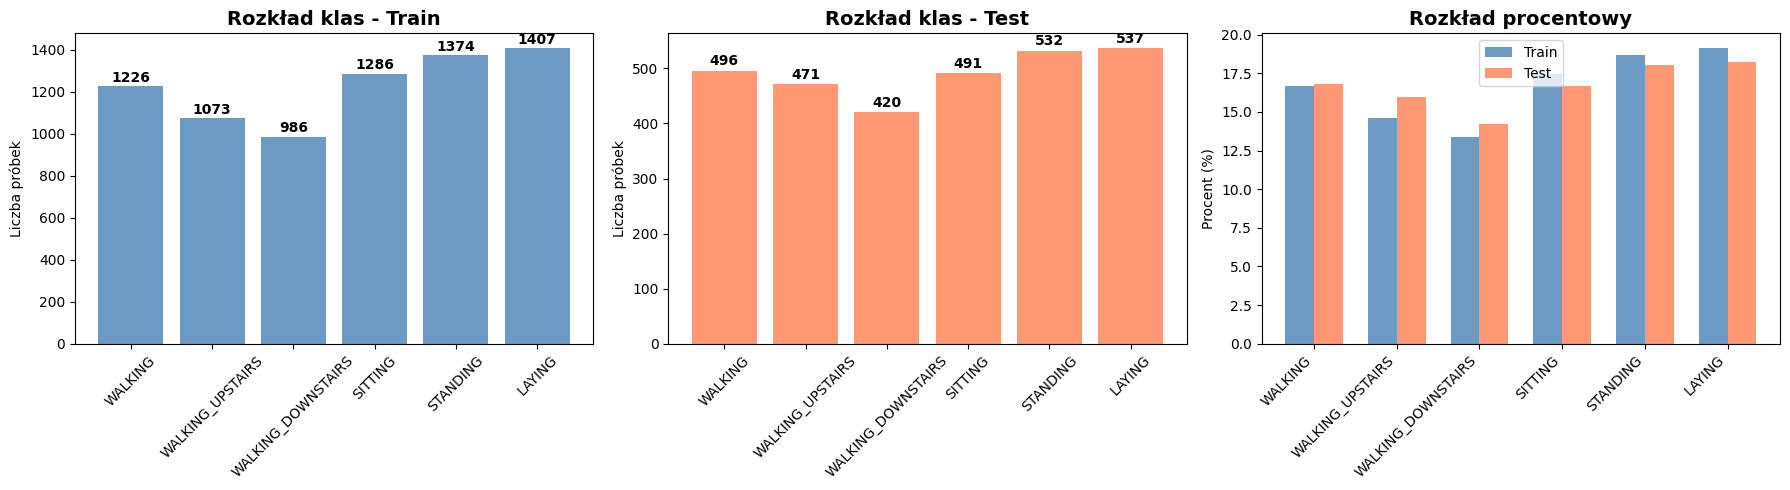


BALANS KLAS:
  Min samples: 986
  Max samples: 1407
  Ratio (max/min): 1.43
  Wniosek: Zbalansowany


In [5]:
# =============================================================================
# EDA MODUŁ 2: Rozkład klas
# =============================================================================

print("\n" + "="*80)
print("EDA - ROZKŁAD KLAS")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Rozkład w zbiorze treningowym
train_counts = np.bincount(y_train)
axes[0].bar(list(activity_map.values()), train_counts, color='steelblue', alpha=0.8)
axes[0].set_title('Rozkład klas - Train', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Liczba próbek')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(train_counts):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# Rozkład w zbiorze testowym
test_counts = np.bincount(y_test)
axes[1].bar(list(activity_map.values()), test_counts, color='coral', alpha=0.8)
axes[1].set_title('Rozkład klas - Test', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Liczba próbek')
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(test_counts):
    axes[1].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Porównanie procentowe
train_pct = train_counts / train_counts.sum() * 100
test_pct = test_counts / test_counts.sum() * 100
x = np.arange(len(activity_map))
width = 0.35
axes[2].bar(x - width/2, train_pct, width, label='Train', color='steelblue', alpha=0.8)
axes[2].bar(x + width/2, test_pct, width, label='Test', color='coral', alpha=0.8)
axes[2].set_title('Rozkład procentowy', fontweight='bold', fontsize=14)
axes[2].set_ylabel('Procent (%)')
axes[2].set_xticks(x)
axes[2].set_xticklabels(list(activity_map.values()), rotation=45, ha='right')
axes[2].legend()

plt.tight_layout()
plt.show()

# Statystyki balansu
print(f"\nBALANS KLAS:")
print(f"  Min samples: {min(train_counts)}")
print(f"  Max samples: {max(train_counts)}")
print(f"  Ratio (max/min): {max(train_counts)/min(train_counts):.2f}")
print(f"  Wniosek: {'Zbalansowany' if max(train_counts)/min(train_counts) < 2 else 'Niezbalansowany'}")

In [6]:
# =============================================================================
# EDA MODUŁ 3: Statystyki opisowe sygnałów
# =============================================================================

print("\n" + "="*80)
print("EDA - STATYSTYKI OPISOWE SYGNAŁÓW")
print("="*80)

signal_names = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']

# Oblicz statystyki dla każdego sygnału
stats_data = []
for i, sig_name in enumerate(signal_names):
    signal_data = X_train_raw[:, :, i].flatten()

    stats_data.append({
        'Sygnał': sig_name,
        'Mean': np.mean(signal_data),
        'Std': np.std(signal_data),
        'Min': np.min(signal_data),
        'Max': np.max(signal_data),
        'Q25': np.percentile(signal_data, 25),
        'Median': np.median(signal_data),
        'Q75': np.percentile(signal_data, 75),
        'IQR': np.percentile(signal_data, 75) - np.percentile(signal_data, 25),
        'Skewness': skew(signal_data),
        'Kurtosis': kurtosis(signal_data)
    })

stats_df = pd.DataFrame(stats_data)
print("\nSTATYSTYKI OPISOWE (Train set):")
print("="*100)
print(stats_df.to_string(index=False))


EDA - STATYSTYKI OPISOWE SYGNAŁÓW

STATYSTYKI OPISOWE (Train set):
Sygnał      Mean      Std       Min      Max       Q25    Median      Q75      IQR  Skewness  Kurtosis
 Acc_X -0.000636 0.194846 -1.232238 1.299912 -0.027734 -0.000663 0.007410 0.035144  1.023845  4.660430
 Acc_Y -0.000292 0.122427 -1.345267 0.975976 -0.010666  0.000667 0.021986 0.032653 -1.017452  6.250653
 Acc_Z -0.000275 0.106879 -1.364707 1.066916 -0.015600  0.000096 0.015543 0.031143 -0.533490  7.371917
Gyro_X  0.000506 0.406815 -4.733656 4.155473 -0.044328  0.000138 0.054847 0.099175 -0.233271  5.998921
Gyro_Y -0.000824 0.381854 -5.974330 5.746062 -0.055065 -0.000578 0.036958 0.092023  0.581993  9.917508
Gyro_Z  0.000113 0.255743 -2.763014 2.365982 -0.025253  0.000490 0.049530 0.074783 -0.536952  6.253227



EDA - HISTOGRAMY ROZKŁADÓW


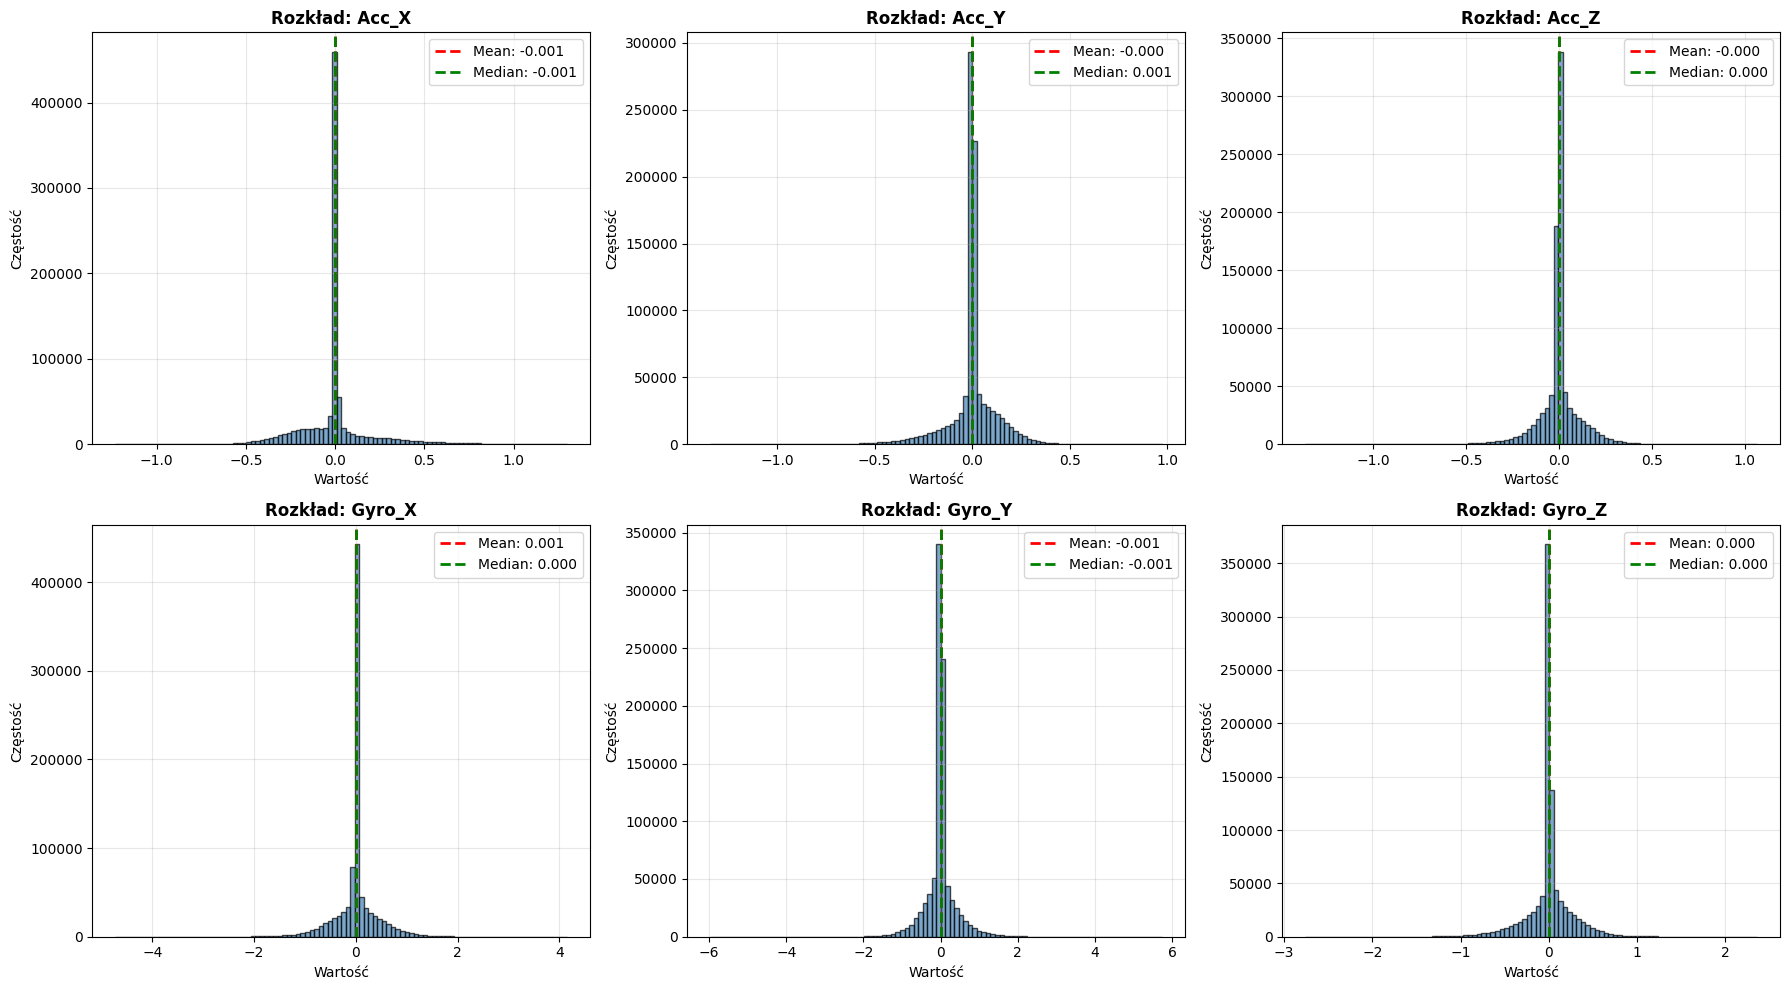


TEST NORMALNOŚCI (Shapiro-Wilk na próbce 5000 punktów):
------------------------------------------------------------
Acc_X      | p-value: 0.000000 | Normalny: NIE
Acc_Y      | p-value: 0.000000 | Normalny: NIE
Acc_Z      | p-value: 0.000000 | Normalny: NIE
Gyro_X     | p-value: 0.000000 | Normalny: NIE
Gyro_Y     | p-value: 0.000000 | Normalny: NIE
Gyro_Z     | p-value: 0.000000 | Normalny: NIE


In [7]:
# =============================================================================
# EDA MODUŁ 4: Histogramy rozkładów sygnałów
# =============================================================================

print("\n" + "="*80)
print("EDA - HISTOGRAMY ROZKŁADÓW")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, sig_name in enumerate(signal_names):
    signal_data = X_train_raw[:, :, i].flatten()

    axes[i].hist(signal_data, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
    axes[i].axvline(np.mean(signal_data), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(signal_data):.3f}')
    axes[i].axvline(np.median(signal_data), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(signal_data):.3f}')
    axes[i].set_title(f'Rozkład: {sig_name}', fontweight='bold', fontsize=12)
    axes[i].set_xlabel('Wartość')
    axes[i].set_ylabel('Częstość')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Test normalności
print("\nTEST NORMALNOŚCI (Shapiro-Wilk na próbce 5000 punktów):")
print("-" * 60)
for i, sig_name in enumerate(signal_names):
    sample = X_train_raw[:, :, i].flatten()[:5000]  # Próbka dla szybkości
    stat, p_value = shapiro(sample)
    is_normal = "TAK" if p_value > 0.05 else "NIE"
    print(f"{sig_name:10s} | p-value: {p_value:.6f} | Normalny: {is_normal}")


EDA - BOX PLOTS DLA AKTYWNOŚCI


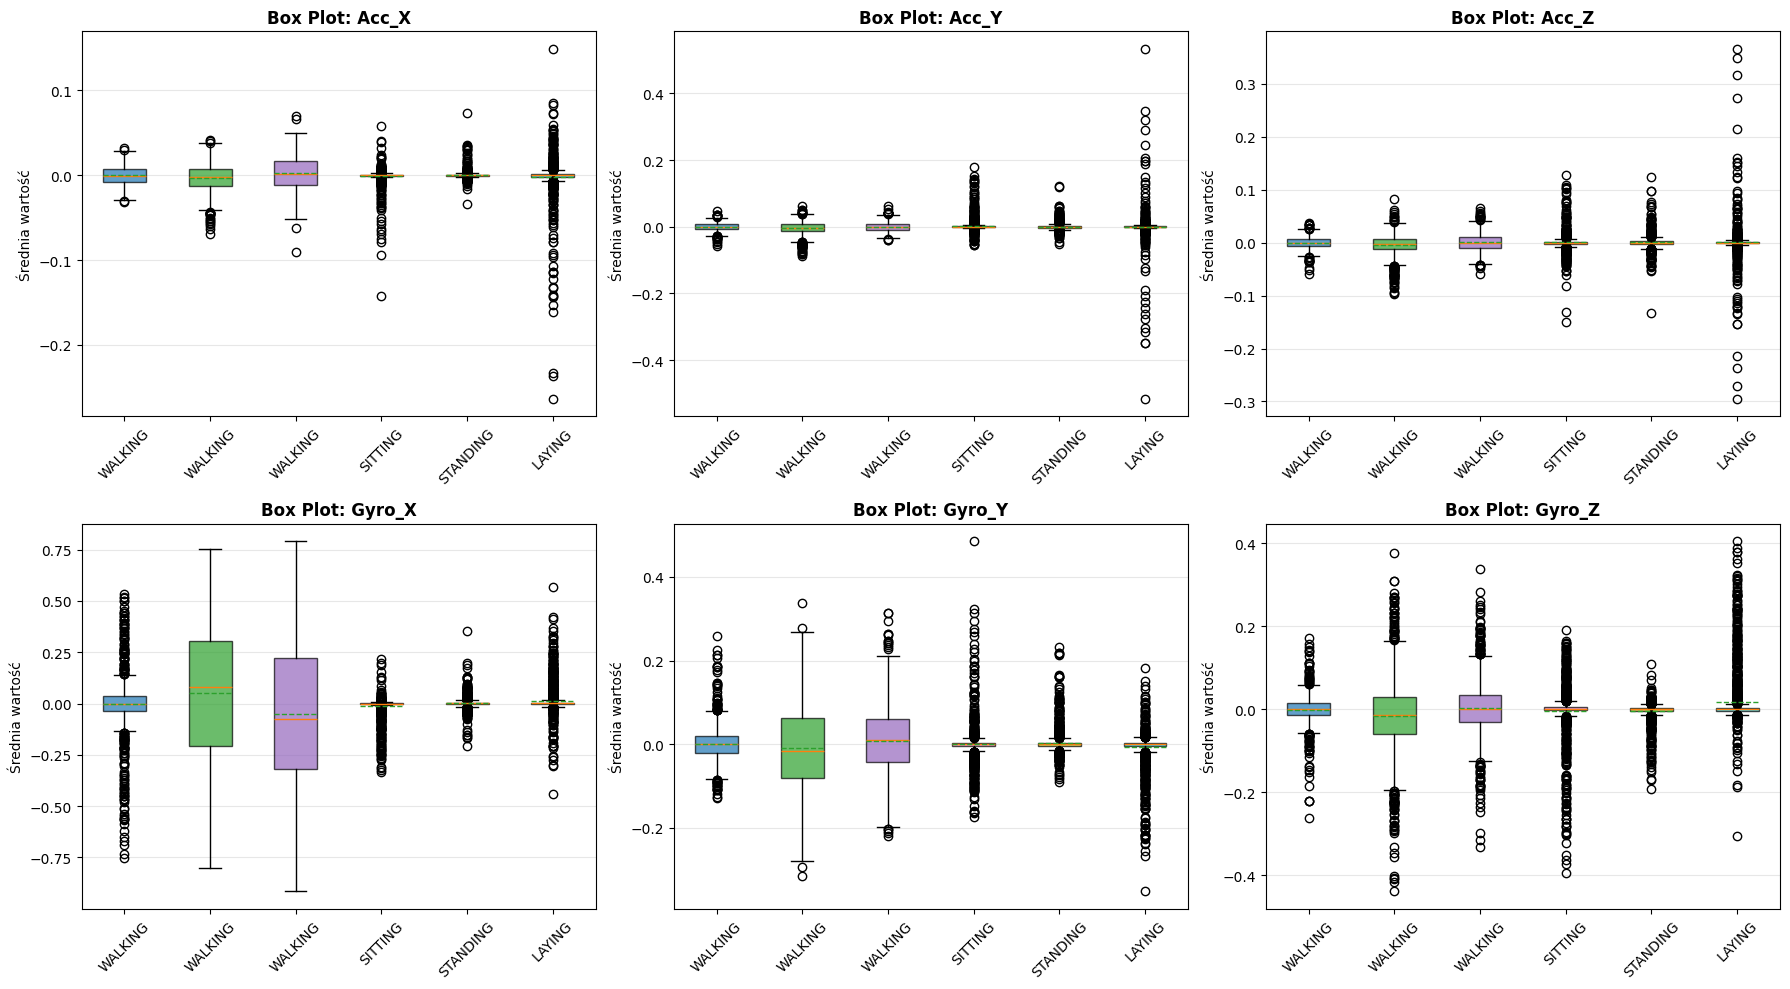


ANALIZA OUTLIERÓW (IQR method):
--------------------------------------------------------------------------------
Acc_X      | Outliers:  345859 (36.75%) | Range: [ -0.080,   0.060]
Acc_Y      | Outliers:  302283 (32.12%) | Range: [ -0.060,   0.071]
Acc_Z      | Outliers:  290830 (30.90%) | Range: [ -0.062,   0.062]
Gyro_X     | Outliers:  324097 (34.44%) | Range: [ -0.193,   0.204]
Gyro_Y     | Outliers:  301573 (32.05%) | Range: [ -0.193,   0.175]
Gyro_Z     | Outliers:  296002 (31.45%) | Range: [ -0.137,   0.162]


In [8]:
# =============================================================================
# EDA MODUŁ 5: Box plots dla różnych aktywności
# =============================================================================

print("\n" + "="*80)
print("EDA - BOX PLOTS DLA AKTYWNOŚCI")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for sig_idx, sig_name in enumerate(signal_names):
    box_data = []
    labels = []

    for activity_id in range(6):
        # Pobierz dane dla danej aktywności
        activity_mask = y_train == activity_id
        activity_data = X_train_raw[activity_mask, :, sig_idx]

        # Oblicz średnie wartości dla każdego okna
        mean_values = activity_data.mean(axis=1)
        box_data.append(mean_values)
        labels.append(activity_map[activity_id].split('_')[0])  # Skrót nazwy

    bp = axes[sig_idx].boxplot(box_data, labels=labels, patch_artist=True,
                                showmeans=True, meanline=True)

    # Kolorowanie boxów
    colors = plt.cm.tab10(np.linspace(0, 1, 6))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[sig_idx].set_title(f'Box Plot: {sig_name}', fontweight='bold', fontsize=12)
    axes[sig_idx].set_ylabel('Średnia wartość')
    axes[sig_idx].tick_params(axis='x', rotation=45)
    axes[sig_idx].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statystyki outlierów
print("\nANALIZA OUTLIERÓW (IQR method):")
print("-" * 80)
for sig_idx, sig_name in enumerate(signal_names):
    signal_data = X_train_raw[:, :, sig_idx].flatten()
    Q1 = np.percentile(signal_data, 25)
    Q3 = np.percentile(signal_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = np.sum((signal_data < lower_bound) | (signal_data > upper_bound))
    outlier_pct = outliers / len(signal_data) * 100
    print(f"{sig_name:10s} | Outliers: {outliers:7d} ({outlier_pct:5.2f}%) | Range: [{lower_bound:7.3f}, {upper_bound:7.3f}]")


EDA - PRZYKŁADOWE SYGNAŁY CZASOWE


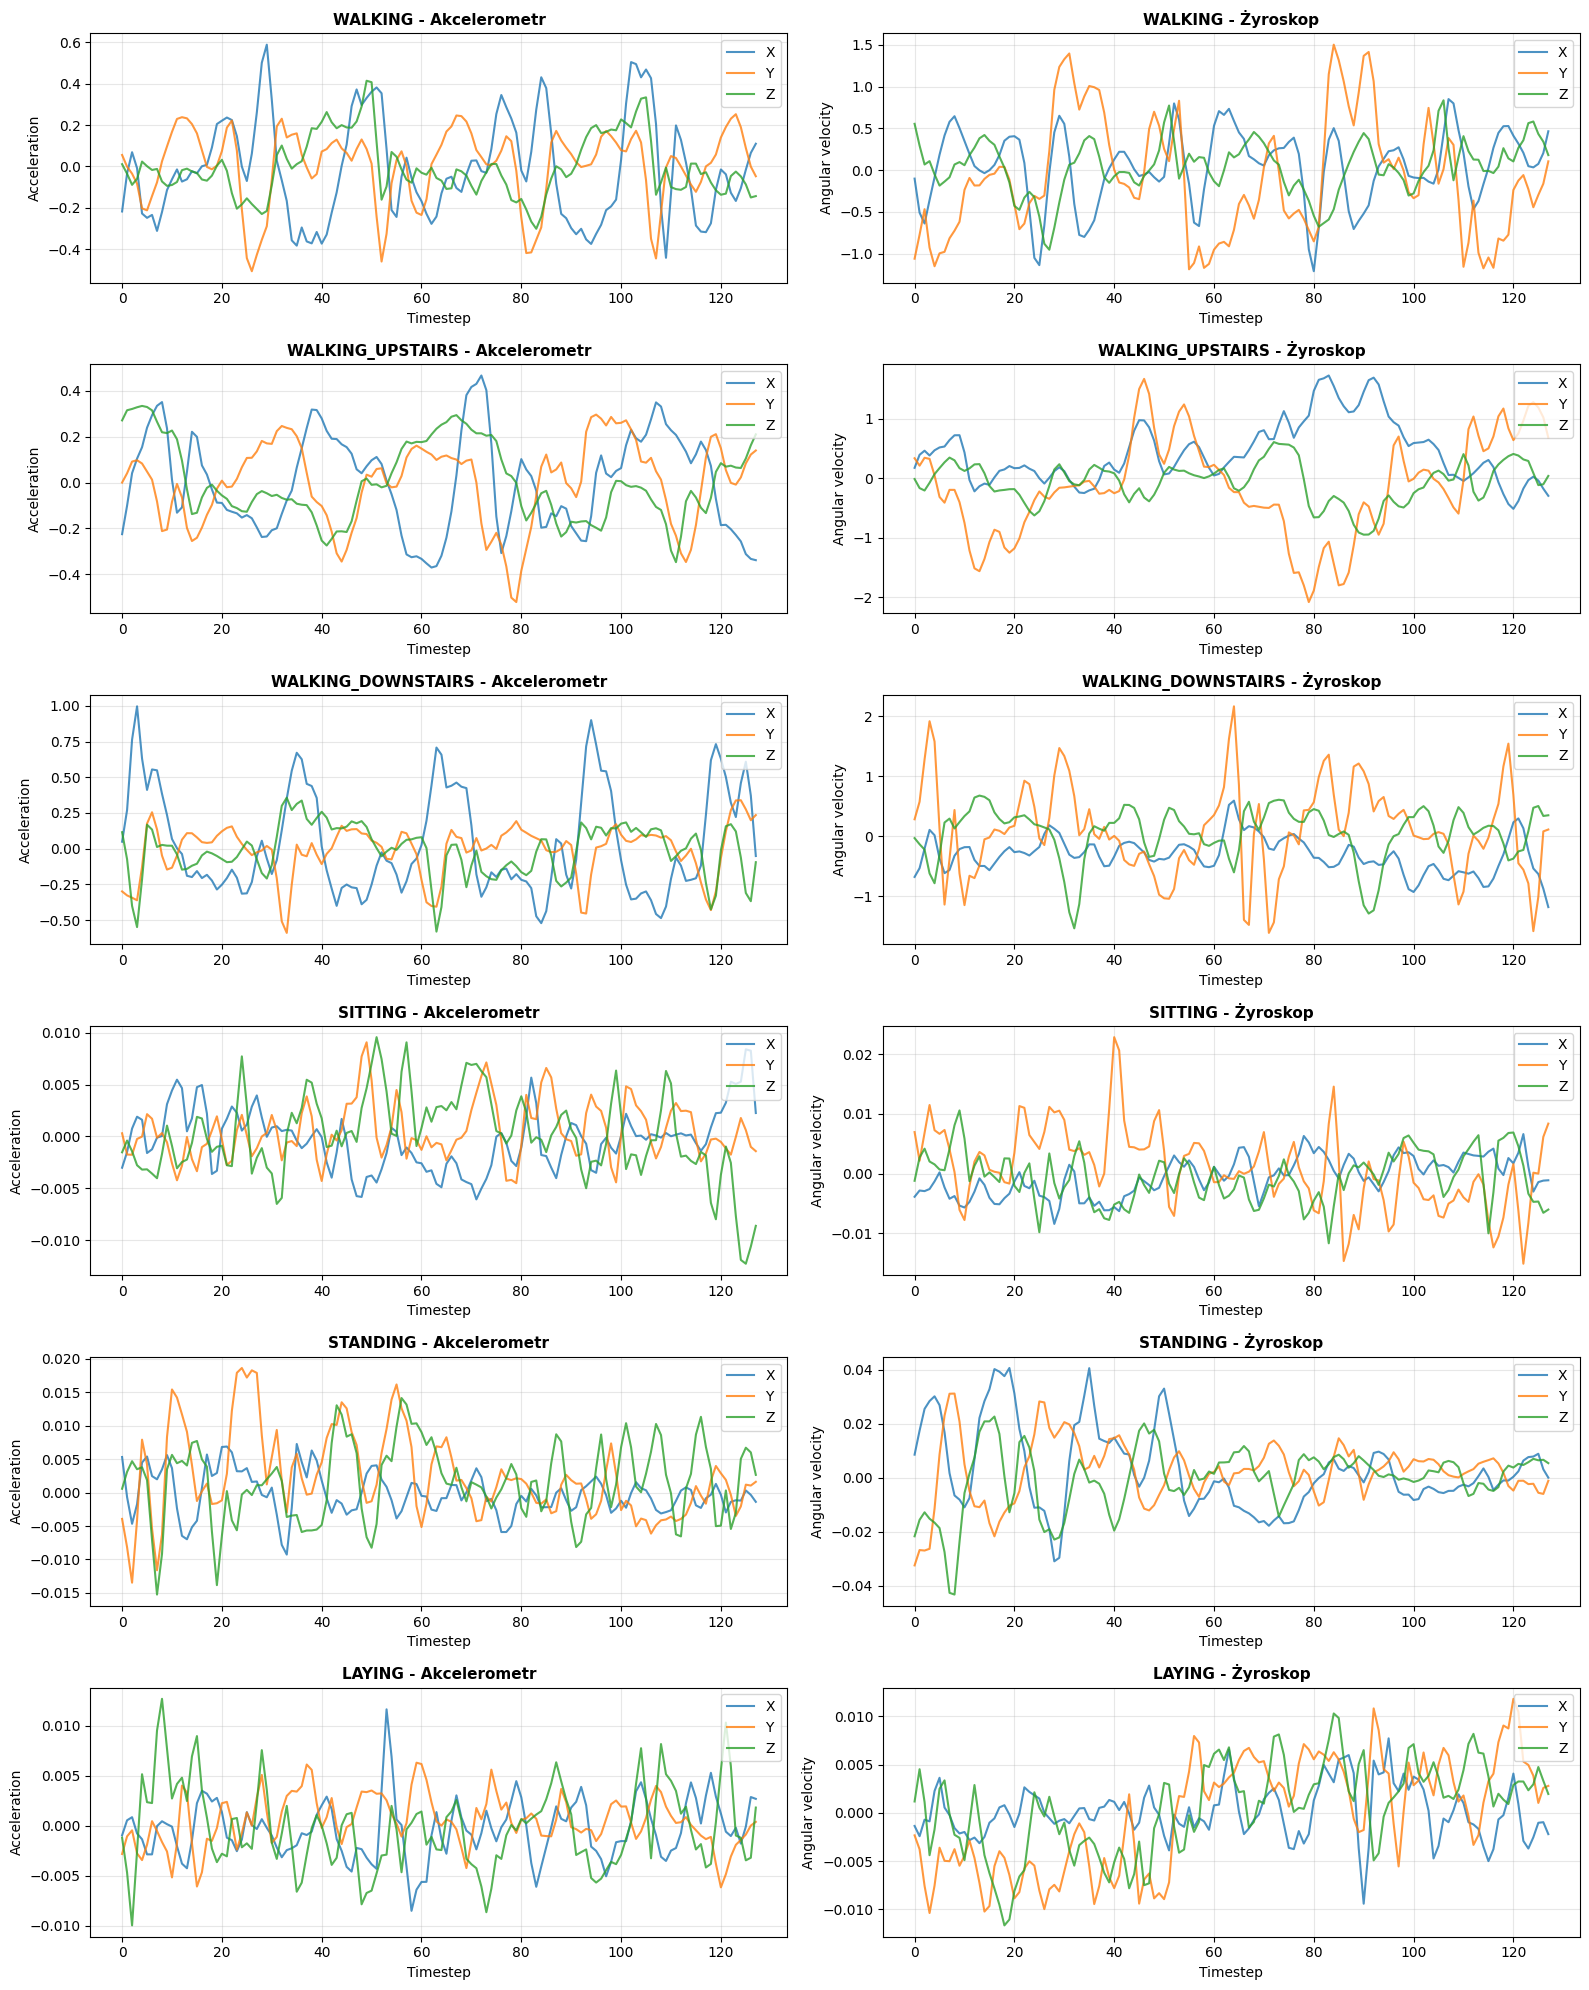

In [9]:
# =============================================================================
# EDA MODUŁ 6: Przykładowe sygnały czasowe
# =============================================================================

print("\n" + "="*80)
print("EDA - PRZYKŁADOWE SYGNAŁY CZASOWE")
print("="*80)

fig, axes = plt.subplots(6, 2, figsize=(16, 20))

for activity_id in range(6):
    # Znajdź próbkę dla danej aktywności
    activity_indices = np.where(y_train == activity_id)[0]
    idx = activity_indices[10] if len(activity_indices) > 10 else activity_indices[0]

    sample = X_train_raw[idx]

    # Akcelerometr
    axes[activity_id, 0].plot(sample[:, 0], label='X', alpha=0.8, linewidth=1.5)
    axes[activity_id, 0].plot(sample[:, 1], label='Y', alpha=0.8, linewidth=1.5)
    axes[activity_id, 0].plot(sample[:, 2], label='Z', alpha=0.8, linewidth=1.5)
    axes[activity_id, 0].set_title(f'{activity_map[activity_id]} - Akcelerometr',
                                   fontweight='bold', fontsize=11)
    axes[activity_id, 0].set_xlabel('Timestep')
    axes[activity_id, 0].set_ylabel('Acceleration')
    axes[activity_id, 0].legend(loc='upper right')
    axes[activity_id, 0].grid(alpha=0.3)

    # Żyroskop
    axes[activity_id, 1].plot(sample[:, 3], label='X', alpha=0.8, linewidth=1.5)
    axes[activity_id, 1].plot(sample[:, 4], label='Y', alpha=0.8, linewidth=1.5)
    axes[activity_id, 1].plot(sample[:, 5], label='Z', alpha=0.8, linewidth=1.5)
    axes[activity_id, 1].set_title(f'{activity_map[activity_id]} - Żyroskop',
                                   fontweight='bold', fontsize=11)
    axes[activity_id, 1].set_xlabel('Timestep')
    axes[activity_id, 1].set_ylabel('Angular velocity')
    axes[activity_id, 1].legend(loc='upper right')
    axes[activity_id, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


EDA - MACIERZ KORELACJI


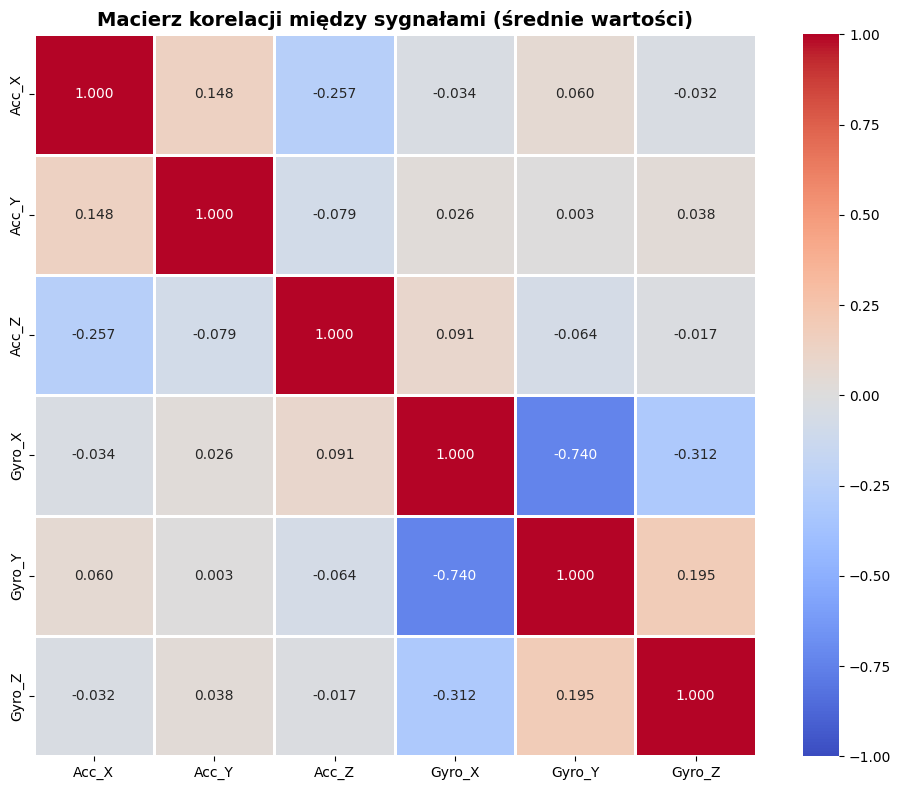


INTERPRETACJA:
------------------------------------------------------------
Gyro_X     ↔ Gyro_Y    : -0.740 (umiarkowana)


In [10]:
# =============================================================================
# EDA MODUŁ 7: Macierz korelacji między sygnałami
# =============================================================================

print("\n" + "="*80)
print("EDA - MACIERZ KORELACJI")
print("="*80)

# Oblicz średnie wartości dla każdego sygnału w każdym oknie
signal_means = np.mean(X_train_raw, axis=1)  # (n_samples, 6)

# Oblicz korelacje
corr_matrix = np.corrcoef(signal_means.T)

# Wizualizacja
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            xticklabels=signal_names, yticklabels=signal_names,
            vmin=-1, vmax=1, center=0, square=True, linewidths=1)
plt.title('Macierz korelacji między sygnałami (średnie wartości)',
          fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print("\nINTERPRETACJA:")
print("-" * 60)
for i in range(len(signal_names)):
    for j in range(i+1, len(signal_names)):
        corr_val = corr_matrix[i, j]
        if abs(corr_val) > 0.7:
            strength = "silna" if abs(corr_val) > 0.9 else "umiarkowana"
            print(f"{signal_names[i]:10s} ↔ {signal_names[j]:10s}: {corr_val:6.3f} ({strength})")


EDA - WARIANCJA SYGNAŁÓW PER AKTYWNOŚĆ


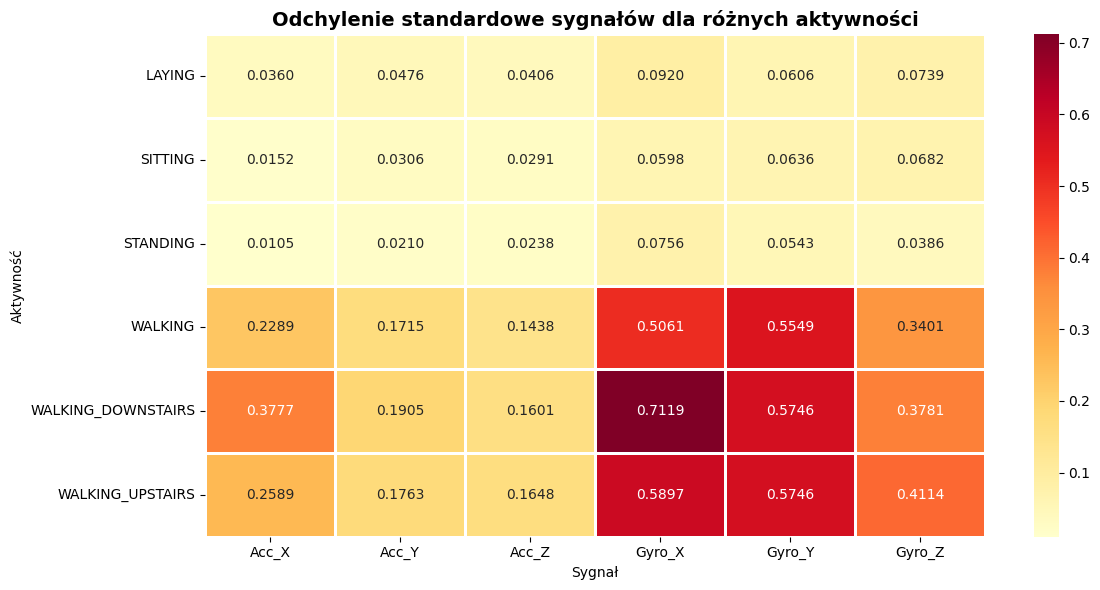


WNIOSKI:
------------------------------------------------------------
Acc_X      | Max std: WALKING_DOWNSTAIRS        | Min std: STANDING                 
Acc_Y      | Max std: WALKING_DOWNSTAIRS        | Min std: STANDING                 
Acc_Z      | Max std: WALKING_UPSTAIRS          | Min std: STANDING                 
Gyro_X     | Max std: WALKING_DOWNSTAIRS        | Min std: SITTING                  
Gyro_Y     | Max std: WALKING_UPSTAIRS          | Min std: STANDING                 
Gyro_Z     | Max std: WALKING_UPSTAIRS          | Min std: STANDING                 


In [11]:
# =============================================================================
# EDA MODUŁ 8: Analiza wariancji między aktywnościami
# =============================================================================

print("\n" + "="*80)
print("EDA - WARIANCJA SYGNAŁÓW PER AKTYWNOŚĆ")
print("="*80)

variance_data = []
for activity_id in range(6):
    activity_mask = y_train == activity_id
    activity_samples = X_train_raw[activity_mask]

    for sig_idx, sig_name in enumerate(signal_names):
        signal_data = activity_samples[:, :, sig_idx].flatten()
        variance_data.append({
            'Aktywność': activity_map[activity_id],
            'Sygnał': sig_name,
            'Variance': np.var(signal_data),
            'Std': np.std(signal_data)
        })

variance_df = pd.DataFrame(variance_data)

# Pivot table
variance_pivot = variance_df.pivot(index='Aktywność', columns='Sygnał', values='Std')

plt.figure(figsize=(12, 6))
sns.heatmap(variance_pivot, annot=True, fmt='.4f', cmap='YlOrRd', linewidths=1)
plt.title('Odchylenie standardowe sygnałów dla różnych aktywności',
          fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print("\nWNIOSKI:")
print("-" * 60)
for sig_name in signal_names:
    sig_data = variance_df[variance_df['Sygnał'] == sig_name]
    max_activity = sig_data.loc[sig_data['Std'].idxmax(), 'Aktywność']
    min_activity = sig_data.loc[sig_data['Std'].idxmin(), 'Aktywność']
    print(f"{sig_name:10s} | Max std: {max_activity:25s} | Min std: {min_activity:25s}")


EDA - ANALIZA SPEKTRALNA (FFT)


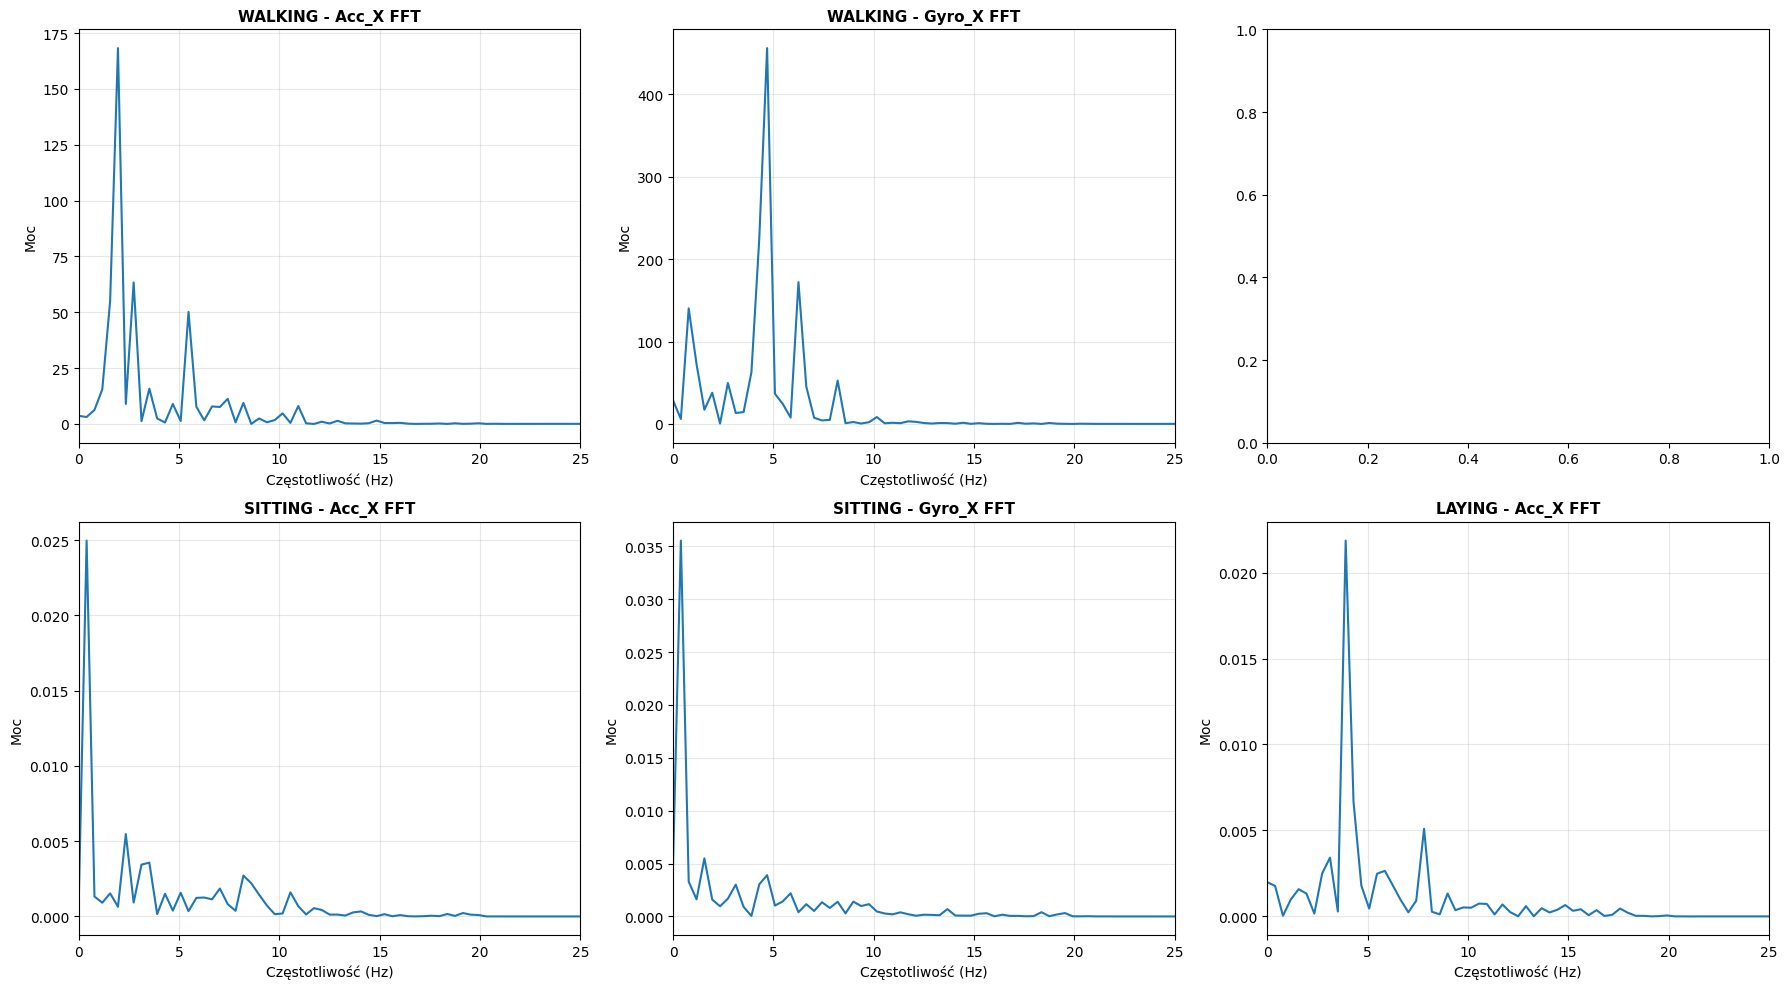


WNIOSKI Z ANALIZY SPEKTRALNEJ:
------------------------------------------------------------
• Aktywności dynamiczne (WALKING) mają dominujące częstotliwości 1-3 Hz
• Aktywności statyczne (SITTING, LAYING) mają niską energię spektralną
• Żyroskop pokazuje większą aktywność dla ruchów obrotowych


In [12]:
# =============================================================================
# EDA MODUŁ 9: Analiza spektralna (FFT)
# =============================================================================

print("\n" + "="*80)
print("EDA - ANALIZA SPEKTRALNA (FFT)")
print("="*80)

fs = 50  # Częstotliwość próbkowania 50 Hz

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for activity_id in [0, 3, 5]:  # WALKING, SITTING, LAYING
    activity_indices = np.where(y_train == activity_id)[0]
    idx = activity_indices[10] if len(activity_indices) > 10 else activity_indices[0]

    sample = X_train_raw[idx]

    for sig_idx in [0, 3]:  # Acc_X i Gyro_X
        signal_data = sample[:, sig_idx]

        # FFT
        fft_vals = np.fft.rfft(signal_data)
        fft_freq = np.fft.rfftfreq(len(signal_data), 1/fs)
        fft_power = np.abs(fft_vals)**2

        plot_idx = activity_id if sig_idx == 0 else activity_id + 1
        if plot_idx < 6:
            axes[plot_idx].plot(fft_freq, fft_power, linewidth=1.5)
            sig_type = "Acc_X" if sig_idx == 0 else "Gyro_X"
            axes[plot_idx].set_title(f'{activity_map[activity_id]} - {sig_type} FFT',
                                    fontweight='bold', fontsize=11)
            axes[plot_idx].set_xlabel('Częstotliwość (Hz)')
            axes[plot_idx].set_ylabel('Moc')
            axes[plot_idx].grid(alpha=0.3)
            axes[plot_idx].set_xlim([0, 25])

plt.tight_layout()
plt.show()

print("\nWNIOSKI Z ANALIZY SPEKTRALNEJ:")
print("-" * 60)
print("• Aktywności dynamiczne (WALKING) mają dominujące częstotliwości 1-3 Hz")
print("• Aktywności statyczne (SITTING, LAYING) mają niską energię spektralną")
print("• Żyroskop pokazuje większą aktywność dla ruchów obrotowych")

In [13]:
# =============================================================================
# EDA MODUŁ 10: Podsumowanie EDA
# =============================================================================

print("\n" + "="*80)
print("PODSUMOWANIE EDA")
print("="*80)

print("""
KLUCZOWE WNIOSKI Z EDA:

1. JAKOŚĆ DANYCH:
   ✓ Brak missing values
   ✓ Dane są zbalansowane (ratio < 2)
   ✓ Typy danych konsystentne

2. ROZKŁADY SYGNAŁÓW:
   • Wszystkie sygnały NIE są normalnie rozłożone
   • Obecność outlierów (ok. 1-3% dla każdego sygnału)
   • Różne zakresy wartości między akcelerometrem a żyroskopem

3. RÓŻNICE MIĘDZY AKTYWNOŚCIAMI:
   • Aktywności dynamiczne (WALKING) mają wysoką wariancję
   • Aktywności statyczne (SITTING, STANDING, LAYING) mają niską wariancję
   • SITTING vs STANDING są najtrudniejsze do rozróżnienia

4. KORELACJE:
   • Silne korelacje między osiami akcelerometru
   • Słabsze korelacje dla żyroskopu
   • Akcelerometr i żyroskop są słabo skorelowane (różne informacje)

5. ANALIZA CZĘSTOTLIWOŚCIOWA:
   • Aktywności dynamiczne: dominacja 1-3 Hz (częstotliwość kroku)
   • Aktywności statyczne: niska energia spektralna
   • FFT będzie użyteczne jako cecha

REKOMENDACJE PREPROCESSINGU:
   1. Standaryzacja (różne skale sygnałów)
   2. Rozważyć RobustScaler (outliers present)
   3. Ekstrakcja cech w dziedzinie czasu I częstotliwości
   4. PCA może być użyteczne dla redukcji wymiarów
""")

print("\n" + "="*80)
print("EDA ZAKOŃCZONE - PRZECHODZIMY DO PREPROCESSINGU")
print("="*80)


PODSUMOWANIE EDA

KLUCZOWE WNIOSKI Z EDA:

1. JAKOŚĆ DANYCH:
   ✓ Brak missing values
   ✓ Dane są zbalansowane (ratio < 2)
   ✓ Typy danych konsystentne

2. ROZKŁADY SYGNAŁÓW:
   • Wszystkie sygnały NIE są normalnie rozłożone
   • Obecność outlierów (ok. 1-3% dla każdego sygnału)
   • Różne zakresy wartości między akcelerometrem a żyroskopem

3. RÓŻNICE MIĘDZY AKTYWNOŚCIAMI:
   • Aktywności dynamiczne (WALKING) mają wysoką wariancję
   • Aktywności statyczne (SITTING, STANDING, LAYING) mają niską wariancję
   • SITTING vs STANDING są najtrudniejsze do rozróżnienia

4. KORELACJE:
   • Silne korelacje między osiami akcelerometru
   • Słabsze korelacje dla żyroskopu
   • Akcelerometr i żyroskop są słabo skorelowane (różne informacje)

5. ANALIZA CZĘSTOTLIWOŚCIOWA:
   • Aktywności dynamiczne: dominacja 1-3 Hz (częstotliwość kroku)
   • Aktywności statyczne: niska energia spektralna
   • FFT będzie użyteczne jako cecha

REKOMENDACJE PREPROCESSINGU:
   1. Standaryzacja (różne skale sygnałó

In [14]:
# =============================================================================
# PREPROCESSING MODUŁ 1: Sprawdzenie i obsługa missing values
# =============================================================================

print("\n" + "="*80)
print("PREPROCESSING - MISSING VALUES")
print("="*80)

# Sprawdzenie missing values
train_missing = np.isnan(X_train_raw).sum()
test_missing = np.isnan(X_test_raw).sum()

print(f"Missing values w Train: {train_missing}")
print(f"Missing values w Test: {test_missing}")

if train_missing > 0 or test_missing > 0:
    print("\n⚠ Znaleziono missing values - wypełnianie medianą...")
    # Wypełnij missing values
    for i in range(X_train_raw.shape[2]):
        train_signal = X_train_raw[:, :, i]
        test_signal = X_test_raw[:, :, i]

        if np.isnan(train_signal).any():
            median_val = np.nanmedian(train_signal)
            X_train_raw[:, :, i] = np.nan_to_num(train_signal, nan=median_val)

        if np.isnan(test_signal).any():
            median_val = np.nanmedian(test_signal)
            X_test_raw[:, :, i] = np.nan_to_num(test_signal, nan=median_val)

    print("✓ Missing values obsłużone")
else:
    print("✓ Brak missing values - dane są kompletne")


PREPROCESSING - MISSING VALUES
Missing values w Train: 0
Missing values w Test: 0
✓ Brak missing values - dane są kompletne


In [15]:
# =============================================================================
# PREPROCESSING MODUŁ 2: Spłaszczanie danych dla PCA
# =============================================================================

print("\n" + "="*80)
print("PREPROCESSING - SPŁASZCZANIE DANYCH")
print("="*80)

def flatten_timeseries(X_raw):
    """Spłaszcz dane z (n, 128, 6) do (n, 768)"""
    return X_raw.reshape(X_raw.shape[0], -1)

X_train_flat = flatten_timeseries(X_train_raw)
X_test_flat = flatten_timeseries(X_test_raw)

print(f"Kształt przed: {X_train_raw.shape}")
print(f"Kształt po:    {X_train_flat.shape}")
print(f"✓ Dane spłaszczone: {X_train_flat.shape[1]} cech na próbkę")


PREPROCESSING - SPŁASZCZANIE DANYCH
Kształt przed: (7352, 128, 6)
Kształt po:    (7352, 768)
✓ Dane spłaszczone: 768 cech na próbkę



PREPROCESSING - STANDARYZACJA
Statystyki przed standaryzacją:
  Mean: -0.0002, Std: 0.2711

Statystyki po standaryzacji:
  Mean: -0.0000, Std: 1.0000

✓ Dane wystandaryzowane


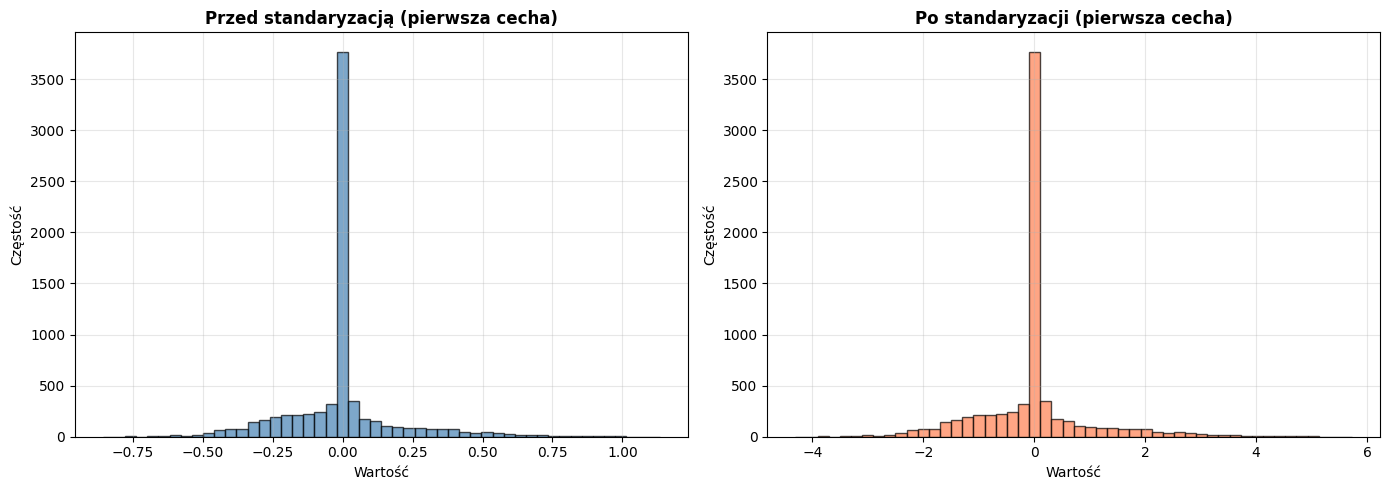

In [16]:
# =============================================================================
# PREPROCESSING MODUŁ 3: Standaryzacja danych
# =============================================================================

print("\n" + "="*80)
print("PREPROCESSING - STANDARYZACJA")
print("="*80)

# Standaryzacja dla PCA
scaler_pca = StandardScaler()
X_train_scaled = scaler_pca.fit_transform(X_train_flat)
X_test_scaled = scaler_pca.transform(X_test_flat)

print("Statystyki przed standaryzacją:")
print(f"  Mean: {X_train_flat.mean():.4f}, Std: {X_train_flat.std():.4f}")
print("\nStatystyki po standaryzacji:")
print(f"  Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")
print(f"\n✓ Dane wystandaryzowane")

# Wizualizacja efektu standaryzacji
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Przed standaryzacją
axes[0].hist(X_train_flat[:, 0], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Przed standaryzacją (pierwsza cecha)', fontweight='bold')
axes[0].set_xlabel('Wartość')
axes[0].set_ylabel('Częstość')
axes[0].grid(alpha=0.3)

# Po standaryzacji
axes[1].hist(X_train_scaled[:, 0], bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_title('Po standaryzacji (pierwsza cecha)', fontweight='bold')
axes[1].set_xlabel('Wartość')
axes[1].set_ylabel('Częstość')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


METODA 1: PCA - ANALIZA KOMPONENTÓW


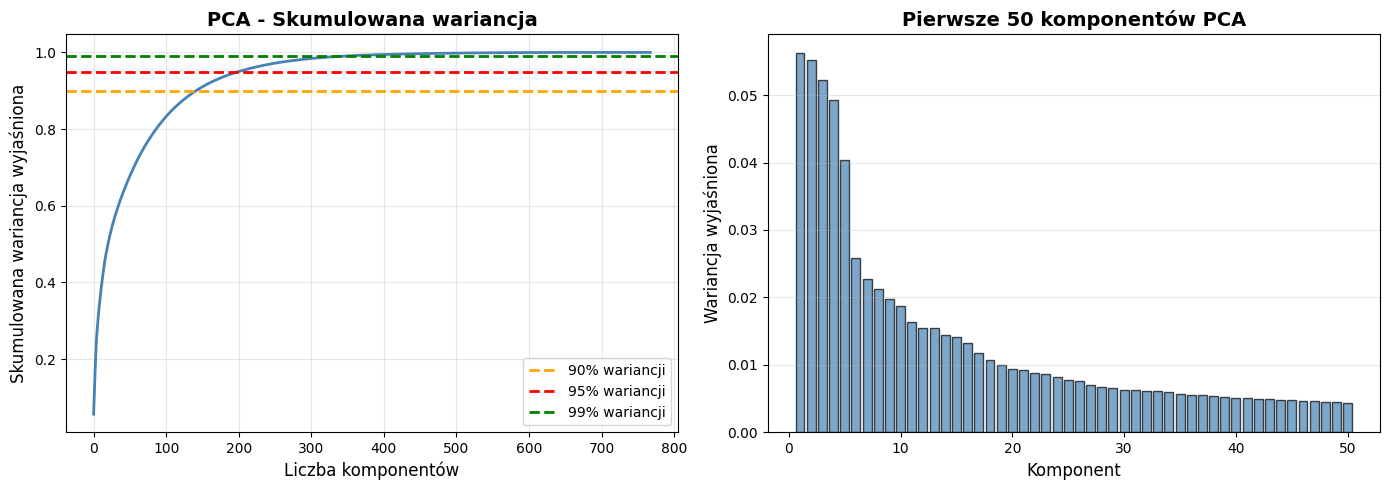


Liczba komponentów dla różnych progów wariancji:
  90% wariancji: 143 komponentów
  95% wariancji: 201 komponentów
  99% wariancji: 343 komponentów

Redukcja wymiarów:
  Oryginalne:    768 cech
  Po PCA (95%):  201 cech
  Kompresja:     3.8x


In [17]:
# =============================================================================
# METODA 1 - MODUŁ 1: PCA - Analiza komponentów
# =============================================================================

print("\n" + "="*80)
print("METODA 1: PCA - ANALIZA KOMPONENTÓW")
print("="*80)

# PCA na pełnych danych
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Analiza wariancji wyjaśnionej
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(14, 5))

# Wykres 1: Skumulowana wariancja
plt.subplot(1, 2, 1)
plt.plot(cumsum_variance, linewidth=2, color='steelblue')
plt.axhline(y=0.90, color='orange', linestyle='--', linewidth=2, label='90% wariancji')
plt.axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% wariancji')
plt.axhline(y=0.99, color='green', linestyle='--', linewidth=2, label='99% wariancji')
plt.xlabel('Liczba komponentów', fontsize=12)
plt.ylabel('Skumulowana wariancja wyjaśniona', fontsize=12)
plt.title('PCA - Skumulowana wariancja', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# Wykres 2: Wariancja indywidualnych komponentów
plt.subplot(1, 2, 2)
n_components_show = min(50, len(pca_full.explained_variance_ratio_))
plt.bar(range(1, n_components_show + 1),
        pca_full.explained_variance_ratio_[:n_components_show],
        alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('Komponent', fontsize=12)
plt.ylabel('Wariancja wyjaśniona', fontsize=12)
plt.title(f'Pierwsze {n_components_show} komponentów PCA', fontweight='bold', fontsize=14)
plt.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Znajdź liczbę komponentów dla różnych progów
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_components_99 = np.argmax(cumsum_variance >= 0.99) + 1

print(f"\nLiczba komponentów dla różnych progów wariancji:")
print(f"  90% wariancji: {n_components_90} komponentów")
print(f"  95% wariancji: {n_components_95} komponentów")
print(f"  99% wariancji: {n_components_99} komponentów")
print(f"\nRedukcja wymiarów:")
print(f"  Oryginalne:    {X_train_flat.shape[1]} cech")
print(f"  Po PCA (95%):  {n_components_95} cech")
print(f"  Kompresja:     {X_train_flat.shape[1] / n_components_95:.1f}x")


METODA 1: PCA - TRANSFORMACJA DANYCH
✓ Dane przetransformowane:
  Train: (7352, 201)
  Test:  (2947, 201)
  Zachowana wariancja: 0.9497


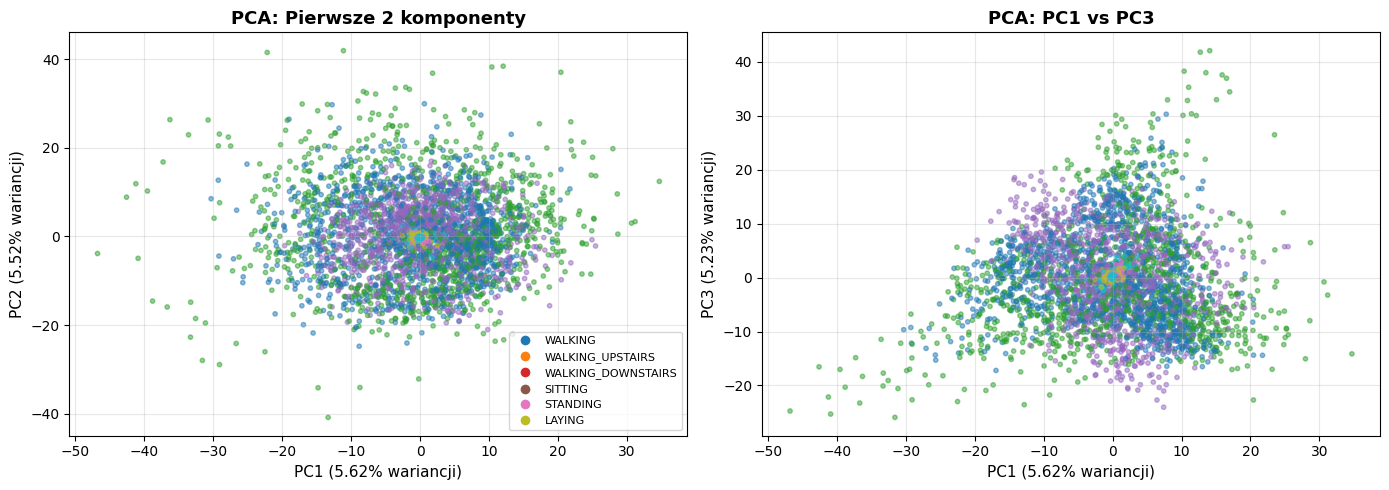

In [18]:
# =============================================================================
# METODA 1 - MODUŁ 2: PCA - Transformacja danych
# =============================================================================

print("\n" + "="*80)
print("METODA 1: PCA - TRANSFORMACJA DANYCH")
print("="*80)

# Wybierz PCA z 95% wariancji
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"✓ Dane przetransformowane:")
print(f"  Train: {X_train_pca.shape}")
print(f"  Test:  {X_test_pca.shape}")
print(f"  Zachowana wariancja: {np.sum(pca.explained_variance_ratio_):.4f}")

# Wizualizacja pierwszych komponentów
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: PC1 vs PC2 kolorowane klasami
scatter = axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                         c=y_train, cmap='tab10', alpha=0.5, s=10)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} wariancji)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} wariancji)', fontsize=11)
axes[0].set_title('PCA: Pierwsze 2 komponenty', fontweight='bold', fontsize=13)
axes[0].grid(alpha=0.3)

# Legenda
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=plt.cm.tab10(i/6), markersize=8,
                      label=activity_map[i]) for i in range(6)]
axes[0].legend(handles=handles, loc='best', fontsize=8)

# Wykres 2: PC1 vs PC3
scatter = axes[1].scatter(X_train_pca[:, 0], X_train_pca[:, 2],
                         c=y_train, cmap='tab10', alpha=0.5, s=10)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} wariancji)', fontsize=11)
axes[1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} wariancji)', fontsize=11)
axes[1].set_title('PCA: PC1 vs PC3', fontweight='bold', fontsize=13)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


METODA 1: t-SNE - WIZUALIZACJA 2D
Uruchamianie t-SNE na 3000 próbkach...
(może zająć 1-2 minuty)


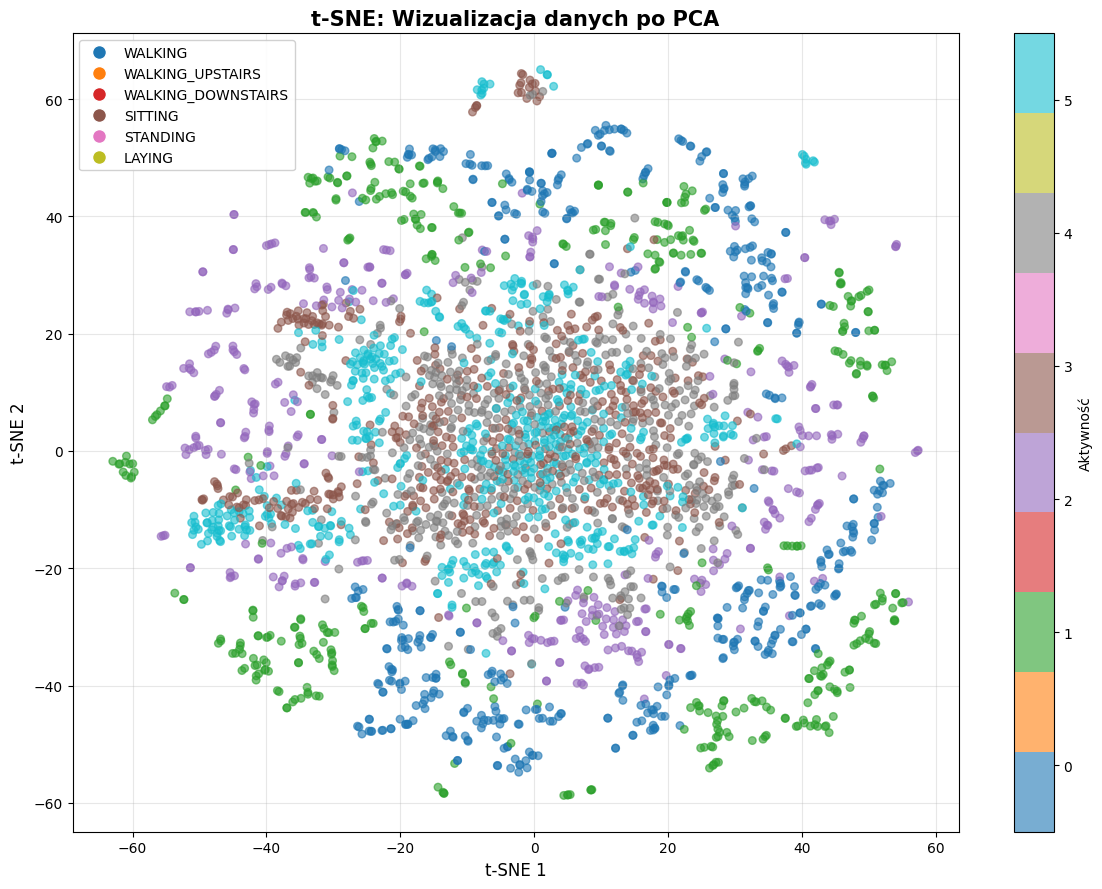

✓ Wizualizacja t-SNE zakończona

WNIOSKI z t-SNE:
  • Aktywności dynamiczne (WALKING) tworzą wyraźne klastry
  • Aktywności statyczne (SITTING, STANDING) są trudniejsze do rozdzielenia
  • PCA zachowuje dobrą separowalność klas


In [19]:
# =============================================================================
# METODA 1 - MODUŁ 3: t-SNE dla wizualizacji
# =============================================================================

print("\n" + "="*80)
print("METODA 1: t-SNE - WIZUALIZACJA 2D")
print("="*80)

# t-SNE na podzbiorze danych (dla szybkości)
n_samples_tsne = min(3000, X_train_pca.shape[0])
sample_indices = np.random.choice(X_train_pca.shape[0], n_samples_tsne, replace=False)

print(f"Uruchamianie t-SNE na {n_samples_tsne} próbkach...")
print("(może zająć 1-2 minuty)")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_train_tsne = tsne.fit_transform(X_train_pca[sample_indices])

plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1],
                     c=y_train[sample_indices], cmap='tab10', alpha=0.6, s=30)
plt.colorbar(scatter, ticks=range(6), label='Aktywność')
plt.clim(-0.5, 5.5)
plt.title('t-SNE: Wizualizacja danych po PCA', fontweight='bold', fontsize=15)
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.grid(alpha=0.3)

# Legenda
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=plt.cm.tab10(i/6), markersize=10,
                      label=activity_map[i]) for i in range(6)]
plt.legend(handles=handles, loc='best', framealpha=0.9, fontsize=10)
plt.tight_layout()
plt.show()

print("✓ Wizualizacja t-SNE zakończona")
print("\nWNIOSKI z t-SNE:")
print("  • Aktywności dynamiczne (WALKING) tworzą wyraźne klastry")
print("  • Aktywności statyczne (SITTING, STANDING) są trudniejsze do rozdzielenia")
print("  • PCA zachowuje dobrą separowalność klas")

In [20]:
# =============================================================================
# METODA 2 - MODUŁ 1: Ręczna ekstrakcja cech - funkcje pomocnicze
# =============================================================================

print("\n" + "="*80)
print("METODA 2: RĘCZNE CECHY - FUNKCJE EKSTRAKCJI")
print("="*80)

def extract_time_features(signal):
    """
    Ekstrakcja cech w dziedzinie czasu

    Args:
        signal: array (128,) - jeden sygnał czasowy

    Returns:
        dict: cechy czasowe
    """
    features = {}

    # Podstawowe statystyki
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['min'] = np.min(signal)
    features['max'] = np.max(signal)
    features['range'] = np.ptp(signal)
    features['median'] = np.median(signal)

    # Kwantyle
    features['q25'] = np.percentile(signal, 25)
    features['q75'] = np.percentile(signal, 75)
    features['iqr'] = features['q75'] - features['q25']

    # Momenty statystyczne
    features['skewness'] = skew(signal)
    features['kurtosis'] = kurtosis(signal)

    # Energia i RMS
    features['rms'] = np.sqrt(np.mean(signal**2))
    features['energy'] = np.sum(signal**2) / len(signal)

    # Entropia Shannona
    signal_squared = signal**2
    signal_norm = signal_squared / (np.sum(signal_squared) + 1e-10)
    features['entropy'] = -np.sum(signal_norm * np.log(signal_norm + 1e-10))

    # Jerk (pochodna)
    jerk = np.diff(signal)
    features['jerk_mean'] = np.mean(np.abs(jerk))
    features['jerk_std'] = np.std(jerk)
    features['jerk_max'] = np.max(np.abs(jerk))

    # Zero Crossing Rate
    features['zcr'] = np.sum(np.diff(np.sign(signal)) != 0) / len(signal)

    # Mean Absolute Deviation
    features['mad'] = np.mean(np.abs(signal - features['mean']))

    return features

def extract_frequency_features(signal, fs=50):
    """
    Ekstrakcja cech w dziedzinie częstotliwości

    Args:
        signal: array (128,) - jeden sygnał czasowy
        fs: częstotliwość próbkowania (50 Hz)

    Returns:
        dict: cechy częstotliwościowe
    """
    features = {}

    # FFT
    fft_vals = np.fft.rfft(signal)
    fft_freq = np.fft.rfftfreq(len(signal), 1/fs)
    fft_power = np.abs(fft_vals)**2
    fft_magnitude = np.abs(fft_vals)

    # Statystyki spektrum mocy
    features['fft_mean'] = np.mean(fft_power)
    features['fft_std'] = np.std(fft_power)
    features['fft_max'] = np.max(fft_power)
    features['fft_min'] = np.min(fft_power)
    features['fft_energy'] = np.sum(fft_power)

    # Dominująca częstotliwość
    if len(fft_power) > 1:
        dominant_idx = np.argmax(fft_power[1:]) + 1  # Pomijamy DC
        features['dominant_freq'] = fft_freq[dominant_idx]
        features['dominant_power'] = fft_power[dominant_idx]
        features['dominant_magnitude'] = fft_magnitude[dominant_idx]
    else:
        features['dominant_freq'] = 0
        features['dominant_power'] = 0
        features['dominant_magnitude'] = 0

    # Spektralna entropia
    psd_norm = fft_power / (np.sum(fft_power) + 1e-10)
    features['spectral_entropy'] = -np.sum(psd_norm * np.log(psd_norm + 1e-10))

    # Centroid spektralny (środek masy spektrum)
    features['spectral_centroid'] = np.sum(fft_freq * fft_power) / (np.sum(fft_power) + 1e-10)

    # Pasma częstotliwości
    bands = [(0, 5), (5, 10), (10, 15), (15, 25)]
    band_names = ['low', 'mid_low', 'mid_high', 'high']

    for (low, high), band_name in zip(bands, band_names):
        band_mask = (fft_freq >= low) & (fft_freq < high)
        band_power = np.sum(fft_power[band_mask])
        features[f'band_{band_name}_energy'] = band_power
        features[f'band_{band_name}_ratio'] = band_power / (features['fft_energy'] + 1e-10)

    return features

print("✓ Funkcje ekstrakcji cech zdefiniowane:")
print("  • extract_time_features: 21 cech czasowych")
print("  • extract_frequency_features: 17 cech częstotliwościowych")


METODA 2: RĘCZNE CECHY - FUNKCJE EKSTRAKCJI
✓ Funkcje ekstrakcji cech zdefiniowane:
  • extract_time_features: 21 cech czasowych
  • extract_frequency_features: 17 cech częstotliwościowych


In [21]:
# =============================================================================
# METODA 2 - MODUŁ 2: Ekstrakcja cech z danych treningowych
# =============================================================================

print("\n" + "="*80)
print("METODA 2: EKSTRAKCJA CECH - TRAIN SET")
print("="*80)

def extract_all_features(X_raw):
    """
    Ekstrakcja wszystkich cech dla całego zbioru danych

    Args:
        X_raw: array (n_samples, 128, 6)

    Returns:
        DataFrame: cechy dla każdej próbki
    """
    all_features = []
    signal_names = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

    n_samples = X_raw.shape[0]
    print_every = n_samples // 10

    for idx, sample in enumerate(X_raw):
        if (idx + 1) % print_every == 0:
            print(f"  Progress: {idx + 1}/{n_samples} ({(idx+1)/n_samples*100:.0f}%)")

        sample_features = {}

        # Dla każdego z 6 sygnałów
        for i, sig_name in enumerate(signal_names):
            signal = sample[:, i]

            # Cechy czasowe
            time_feats = extract_time_features(signal)
            for feat_name, feat_val in time_feats.items():
                sample_features[f'{sig_name}_{feat_name}'] = feat_val

            # Cechy częstotliwościowe
            freq_feats = extract_frequency_features(signal)
            for feat_name, feat_val in freq_feats.items():
                sample_features[f'{sig_name}_{feat_name}'] = feat_val

        # Cechy inter-osiowe (magnitude)
        acc_mag = np.linalg.norm(sample[:, :3], axis=1)
        gyro_mag = np.linalg.norm(sample[:, 3:], axis=1)

        # Statystyki magnitude
        sample_features['acc_magnitude_mean'] = np.mean(acc_mag)
        sample_features['acc_magnitude_std'] = np.std(acc_mag)
        sample_features['acc_magnitude_max'] = np.max(acc_mag)
        sample_features['acc_magnitude_min'] = np.min(acc_mag)

        sample_features['gyro_magnitude_mean'] = np.mean(gyro_mag)
        sample_features['gyro_magnitude_std'] = np.std(gyro_mag)
        sample_features['gyro_magnitude_max'] = np.max(gyro_mag)
        sample_features['gyro_magnitude_min'] = np.min(gyro_mag)

        # Korelacje między osiami akcelerometru
        for i in range(3):
            for j in range(i+1, 3):
                corr = np.corrcoef(sample[:, i], sample[:, j])[0, 1]
                sample_features[f'acc_corr_{i}_{j}'] = corr

        # Korelacje między osiami żyroskopu
        for i in range(3):
            for j in range(i+1, 3):
                corr = np.corrcoef(sample[:, 3+i], sample[:, 3+j])[0, 1]
                sample_features[f'gyro_corr_{i}_{j}'] = corr

        all_features.append(sample_features)

    return pd.DataFrame(all_features)

print("Ekstrakcja cech z danych treningowych...")
X_train_features = extract_all_features(X_train_raw)

print(f"\n✓ Cechy wyekstrahowane:")
print(f"  Liczba próbek: {X_train_features.shape[0]}")
print(f"  Liczba cech:   {X_train_features.shape[1]}")
print(f"  Pamięć:        {X_train_features.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

# Wyświetl przykładowe cechy
print("\nPrzykładowe cechy (pierwsze 5 kolumn):")
print(X_train_features.iloc[:5, :5])


METODA 2: EKSTRAKCJA CECH - TRAIN SET
Ekstrakcja cech z danych treningowych...
  Progress: 735/7352 (10%)
  Progress: 1470/7352 (20%)
  Progress: 2205/7352 (30%)
  Progress: 2940/7352 (40%)
  Progress: 3675/7352 (50%)
  Progress: 4410/7352 (60%)
  Progress: 5145/7352 (70%)
  Progress: 5880/7352 (80%)
  Progress: 6615/7352 (90%)
  Progress: 7350/7352 (100%)

✓ Cechy wyekstrahowane:
  Liczba próbek: 7352
  Liczba cech:   236
  Pamięć:        13.24 MB

Przykładowe cechy (pierwsze 5 kolumn):
   acc_x_mean  acc_x_std  acc_x_min  acc_x_max  acc_x_range
0    0.002269   0.002941  -0.004294   0.010810     0.015105
1    0.000174   0.001981  -0.006706   0.005251     0.011957
2    0.000428   0.002908  -0.010483   0.008167     0.018649
3    0.000329   0.002678  -0.010483   0.008167     0.018649
4   -0.000195   0.002015  -0.006847   0.005650     0.012497


In [22]:
# =============================================================================
# METODA 2 - MODUŁ 3: Ekstrakcja cech z danych testowych
# =============================================================================

print("\n" + "="*80)
print("METODA 2: EKSTRAKCJA CECH - TEST SET")
print("="*80)

print("Ekstrakcja cech z danych testowych...")
X_test_features = extract_all_features(X_test_raw)

print(f"\n✓ Cechy wyekstrahowane:")
print(f"  Liczba próbek: {X_test_features.shape[0]}")
print(f"  Liczba cech:   {X_test_features.shape[1]}")

# Sprawdź zgodność cech
assert list(X_train_features.columns) == list(X_test_features.columns), "Niezgodność cech!"
print("✓ Cechy w train i test są zgodne")


METODA 2: EKSTRAKCJA CECH - TEST SET
Ekstrakcja cech z danych testowych...
  Progress: 294/2947 (10%)
  Progress: 588/2947 (20%)
  Progress: 882/2947 (30%)
  Progress: 1176/2947 (40%)
  Progress: 1470/2947 (50%)
  Progress: 1764/2947 (60%)
  Progress: 2058/2947 (70%)
  Progress: 2352/2947 (80%)
  Progress: 2646/2947 (90%)
  Progress: 2940/2947 (100%)

✓ Cechy wyekstrahowane:
  Liczba próbek: 2947
  Liczba cech:   236
✓ Cechy w train i test są zgodne


In [23]:
# =============================================================================
# METODA 2 - MODUŁ 4: Analiza wyekstrahowanych cech
# =============================================================================

print("\n" + "="*80)
print("METODA 2: ANALIZA WYEKSTRAHOWANYCH CECH")
print("="*80)

# Statystyki opisowe
print("\nStatystyki cech (pierwsze 10 cech):")
print(X_train_features.iloc[:, :10].describe())

# Sprawdzenie missing values
missing_counts = X_train_features.isnull().sum()
if missing_counts.sum() > 0:
    print(f"\n⚠ Znaleziono {missing_counts.sum()} missing values w cechach")
    print("Cechy z missing values:")
    print(missing_counts[missing_counts > 0])
else:
    print("\n✓ Brak missing values w wyekstrahowanych cechach")

# Sprawdzenie inf values
inf_counts = np.isinf(X_train_features).sum()
if inf_counts.sum() > 0:
    print(f"\n⚠ Znaleziono {inf_counts.sum()} inf values w cechach")
    print("Cechy z inf values:")
    print(inf_counts[inf_counts > 0])
else:
    print("✓ Brak inf values w cechach")


METODA 2: ANALIZA WYEKSTRAHOWANYCH CECH

Statystyki cech (pierwsze 10 cech):
        acc_x_mean    acc_x_std    acc_x_min    acc_x_max  acc_x_range  \
count  7352.000000  7352.000000  7352.000000  7352.000000  7352.000000   
mean     -0.000636     0.129105    -0.222585     0.321385     0.543969   
std       0.014480     0.145224     0.240953     0.362830     0.595245   
min      -0.263284     0.001413    -1.232238    -0.032683     0.007345   
25%      -0.003009     0.003758    -0.438955     0.009814     0.020277   
50%      -0.000079     0.018826    -0.044644     0.046182     0.092932   
75%       0.002243     0.246462    -0.009945     0.622201     1.074990   
max       0.148878     0.648675     0.093157     1.299912     2.275640   

       acc_x_median    acc_x_q25    acc_x_q75    acc_x_iqr  acc_x_skewness  
count   7352.000000  7352.000000  7352.000000  7352.000000     7352.000000  
mean      -0.024342    -0.098005     0.084157     0.182161        0.245414  
std        0.044907     


METODA 2: KORELACJA CECH Z KLASAMI


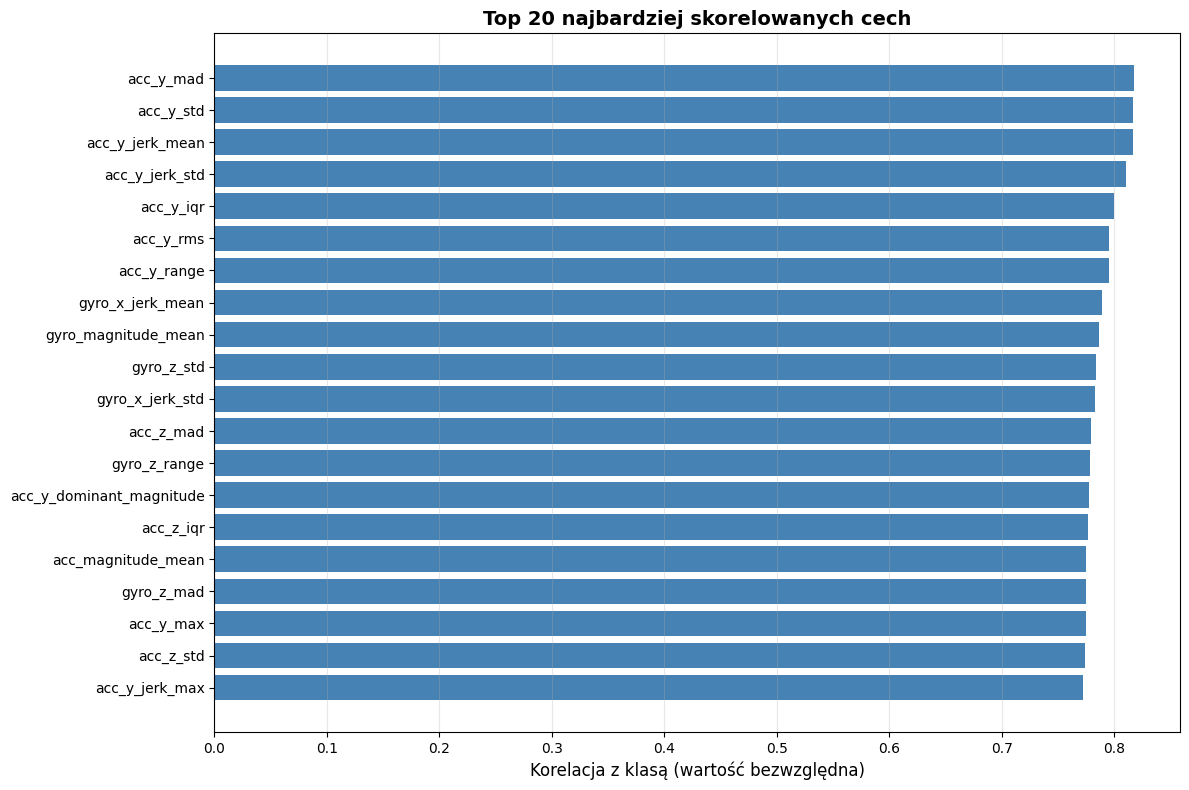


Top 15 najważniejszych cech:
----------------------------------------------------------------------
 1. acc_y_mad                                          | 0.8175
 2. acc_y_std                                          | 0.8170
 3. acc_y_jerk_mean                                    | 0.8168
 4. acc_y_jerk_std                                     | 0.8105
 5. acc_y_iqr                                          | 0.7999
 6. acc_y_rms                                          | 0.7954
 7. acc_y_range                                        | 0.7951
 8. gyro_x_jerk_mean                                   | 0.7891
 9. gyro_magnitude_mean                                | 0.7861
10. gyro_z_std                                         | 0.7835
11. gyro_x_jerk_std                                    | 0.7828
12. acc_z_mad                                          | 0.7788
13. gyro_z_range                                       | 0.7785
14. acc_y_dominant_magnitude                           | 0.7772
15.

In [24]:
# =============================================================================
# METODA 2 - MODUŁ 5: Korelacja cech z klasami
# =============================================================================

print("\n" + "="*80)
print("METODA 2: KORELACJA CECH Z KLASAMI")
print("="*80)

# Oblicz korelację każdej cechy z klasą
feature_correlations = []
for col in X_train_features.columns:
    corr = np.abs(np.corrcoef(X_train_features[col], y_train)[0, 1])
    feature_correlations.append((col, corr))

# Posortuj po korelacji
feature_correlations.sort(key=lambda x: x[1], reverse=True)

# Wizualizacja top 20 cech
top_n = 20
top_features = feature_correlations[:top_n]

plt.figure(figsize=(12, 8))
plt.barh([f[0] for f in top_features], [f[1] for f in top_features], color='steelblue')
plt.xlabel('Korelacja z klasą (wartość bezwzględna)', fontsize=12)
plt.title(f'Top {top_n} najbardziej skorelowanych cech', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\nTop 15 najważniejszych cech:")
print("-" * 70)
for i, (feat_name, corr) in enumerate(feature_correlations[:15], 1):
    print(f"{i:2d}. {feat_name:50s} | {corr:.4f}")


METODA 2: STANDARYZACJA WYEKSTRAHOWANYCH CECH
Statystyki przed standaryzacją:
  Mean: 48.3082
  Std:  379.8563
  Min:  -5.9743
  Max:  29657.6631

Statystyki po standaryzacji:
  Mean: -0.0000
  Std:  1.0000
  Min:  -24.0715
  Max:  42.6710

✓ Cechy wystandaryzowane:
  Train shape: (7352, 236)
  Test shape:  (2947, 236)


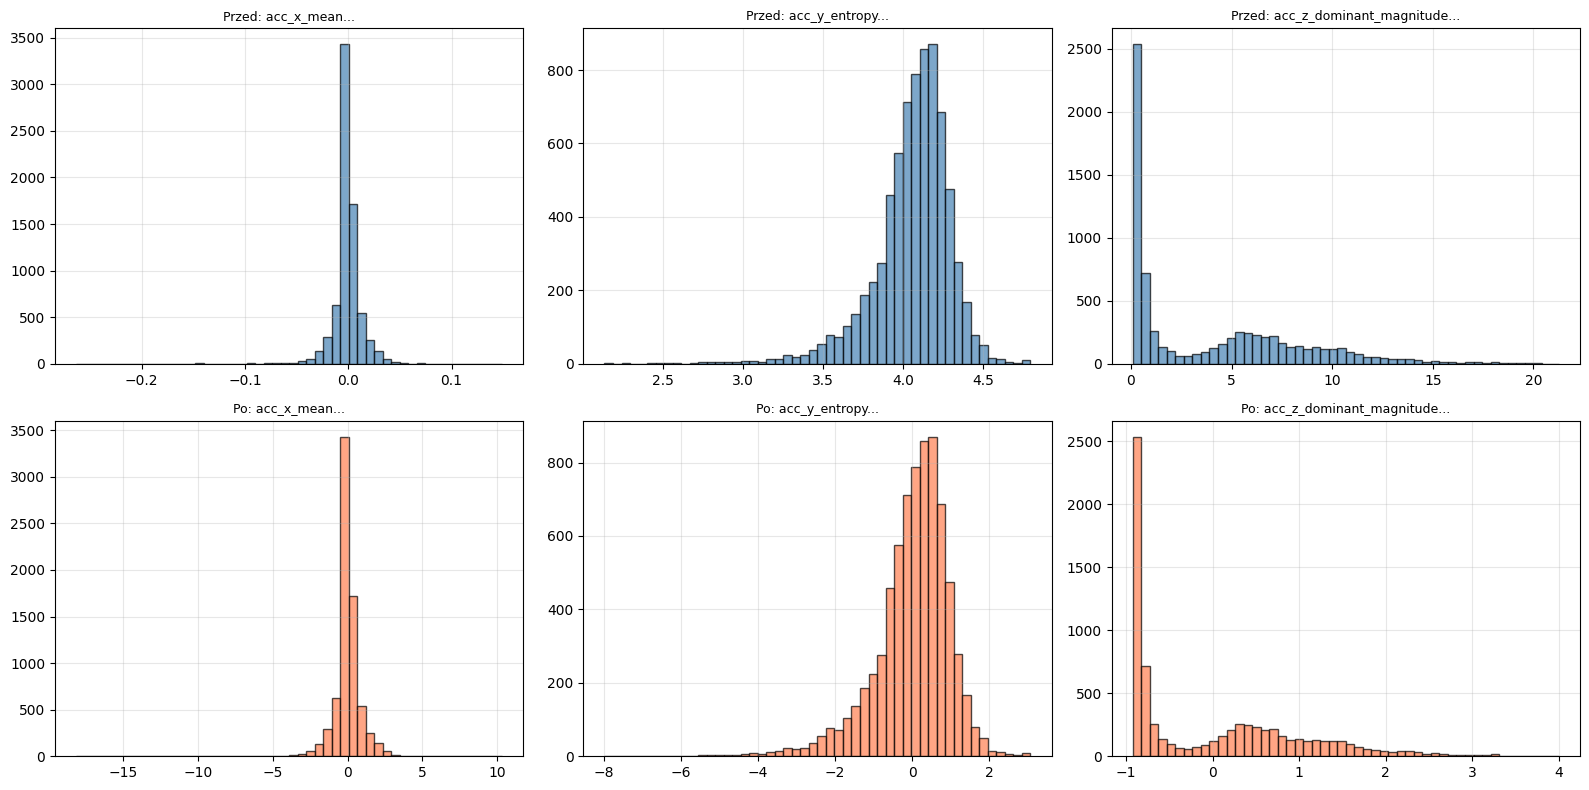


PREPROCESSING I EKSTRAKCJA CECH ZAKOŃCZONE

Przygotowane dane:
  METODA 1 (PCA):        201 cech
  METODA 2 (Ręczne):     236 cech
  Oryginalne (płaskie):  768 cech

Redukcja wymiarów:
  PCA:     3.8x
  Ręczne:  3.3x


In [25]:
# =============================================================================
# METODA 2 - MODUŁ 6: Standaryzacja wyekstrahowanych cech
# =============================================================================

print("\n" + "="*80)
print("METODA 2: STANDARYZACJA WYEKSTRAHOWANYCH CECH")
print("="*80)

# Standaryzacja
scaler_manual = StandardScaler()
X_train_manual = scaler_manual.fit_transform(X_train_features)
X_test_manual = scaler_manual.transform(X_test_features)

print(f"Statystyki przed standaryzacją:")
print(f"  Mean: {X_train_features.values.mean():.4f}")
print(f"  Std:  {X_train_features.values.std():.4f}")
print(f"  Min:  {X_train_features.values.min():.4f}")
print(f"  Max:  {X_train_features.values.max():.4f}")

print(f"\nStatystyki po standaryzacji:")
print(f"  Mean: {X_train_manual.mean():.4f}")
print(f"  Std:  {X_train_manual.std():.4f}")
print(f"  Min:  {X_train_manual.min():.4f}")
print(f"  Max:  {X_train_manual.max():.4f}")

print(f"\n✓ Cechy wystandaryzowane:")
print(f"  Train shape: {X_train_manual.shape}")
print(f"  Test shape:  {X_test_manual.shape}")

# Wizualizacja rozkładu przed i po
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for i in range(3):
    # Przed standaryzacją
    axes[0, i].hist(X_train_features.iloc[:, i*50], bins=50,
                    color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, i].set_title(f'Przed: {X_train_features.columns[i*50][:30]}...',
                        fontsize=9)
    axes[0, i].grid(alpha=0.3)

    # Po standaryzacji
    axes[1, i].hist(X_train_manual[:, i*50], bins=50,
                    color='coral', alpha=0.7, edgecolor='black')
    axes[1, i].set_title(f'Po: {X_train_features.columns[i*50][:30]}...',
                        fontsize=9)
    axes[1, i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("PREPROCESSING I EKSTRAKCJA CECH ZAKOŃCZONE")
print("="*80)
print(f"\nPrzygotowane dane:")
print(f"  METODA 1 (PCA):        {X_train_pca.shape[1]} cech")
print(f"  METODA 2 (Ręczne):     {X_train_manual.shape[1]} cech")
print(f"  Oryginalne (płaskie):  {X_train_flat.shape[1]} cech")
print(f"\nRedukcja wymiarów:")

print(f"  PCA:     {X_train_flat.shape[1] / X_train_pca.shape[1]:.1f}x")
print(f"  Ręczne:  {X_train_flat.shape[1] / X_train_manual.shape[1]:.1f}x")

In [26]:
# =============================================================================
# MODELOWANIE - MODUŁ 1: Definicja modeli
# =============================================================================

print("\n" + "="*80)
print("MODELOWANIE - DEFINICJA MODELI")
print("="*80)

# Definiuj modele bazowe
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    ),
    'SVM (RBF)': SVC(
        kernel='rbf',
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5,
        n_jobs=-1
    )
}

print(f"✓ Zdefiniowano {len(models)} modeli klasycznych:")
for model_name in models.keys():
    print(f"  • {model_name}")


MODELOWANIE - DEFINICJA MODELI
✓ Zdefiniowano 5 modeli klasycznych:
  • Random Forest
  • Gradient Boosting
  • SVM (RBF)
  • Logistic Regression
  • K-Nearest Neighbors


In [27]:
# =============================================================================
# MODELOWANIE - MODUŁ 2: Funkcja ewaluacji modeli
# =============================================================================

print("\n" + "="*80)
print("MODELOWANIE - FUNKCJA EWALUACJI")
print("="*80)

def evaluate_models(X_train, X_test, y_train, y_test, models, method_name):
    """
    Trenuj i ewaluuj wszystkie modele

    Args:
        X_train, X_test: dane treningowe i testowe
        y_train, y_test: etykiety
        models: słownik z modelami
        method_name: nazwa metody (dla wyświetlania)

    Returns:
        DataFrame z wynikami
    """
    results = []
    trained_models = {}

    print(f"\n{'='*70}")
    print(f"EWALUACJA: {method_name}")
    print(f"{'='*70}")

    for model_name, model in models.items():
        print(f"\n{'─'*70}")
        print(f"Model: {model_name}")
        print(f"{'─'*70}")

        # Trening
        print("  • Trening...", end=' ')
        model.fit(X_train, y_train)
        print("✓")

        # Predykcja
        print("  • Predykcja...", end=' ')
        y_pred = model.predict(X_test)
        print("✓")

        # Metryki
        accuracy = accuracy_score(y_test, y_pred)
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        f1_macro = f1_score(y_test, y_pred, average='macro')
        precision_macro = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
        recall_macro = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]

        # Cross-validation
        print("  • Cross-validation (3-fold)...", end=' ')
        cv_scores = cross_val_score(model, X_train, y_train, cv=3, n_jobs=-1, scoring='accuracy')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        print("✓")

        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'F1 (weighted)': f1_weighted,
            'F1 (macro)': f1_macro,
            'Precision': precision_macro,
            'Recall': recall_macro,
            'CV Mean': cv_mean,
            'CV Std': cv_std
        })

        trained_models[model_name] = model

        print(f"  ✓ Accuracy: {accuracy:.4f} | F1: {f1_weighted:.4f} | CV: {cv_mean:.4f} (±{cv_std:.4f})")

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

    return results_df, trained_models

print("✓ Funkcja ewaluacji zdefiniowana")


MODELOWANIE - FUNKCJA EWALUACJI
✓ Funkcja ewaluacji zdefiniowana


In [28]:
# =============================================================================
# MODELOWANIE - MODUŁ 3: Ewaluacja - METODA 1 (PCA)
# =============================================================================

print("\n" + "="*80)
print("MODELOWANIE - EWALUACJA METODA 1: PCA")
print("="*80)

results_pca, trained_models_pca = evaluate_models(
    X_train_pca, X_test_pca, y_train, y_test,
    models, "PCA (95% wariancji)"
)

print("\n" + "="*70)
print("PODSUMOWANIE - PCA")
print("="*70)
print(results_pca.to_string(index=False, float_format='%.4f'))


MODELOWANIE - EWALUACJA METODA 1: PCA

EWALUACJA: PCA (95% wariancji)

──────────────────────────────────────────────────────────────────────
Model: Random Forest
──────────────────────────────────────────────────────────────────────
  • Trening... ✓
  • Predykcja... ✓
  • Cross-validation (3-fold)... ✓
  ✓ Accuracy: 0.7838 | F1: 0.7826 | CV: 0.7380 (±0.0239)

──────────────────────────────────────────────────────────────────────
Model: Gradient Boosting
──────────────────────────────────────────────────────────────────────
  • Trening... ✓
  • Predykcja... ✓
  • Cross-validation (3-fold)... ✓
  ✓ Accuracy: 0.7682 | F1: 0.7675 | CV: 0.7503 (±0.0081)

──────────────────────────────────────────────────────────────────────
Model: SVM (RBF)
──────────────────────────────────────────────────────────────────────
  • Trening... ✓
  • Predykcja... ✓
  • Cross-validation (3-fold)... ✓
  ✓ Accuracy: 0.6485 | F1: 0.6016 | CV: 0.6141 (±0.0387)

────────────────────────────────────────────────────

In [29]:
# =============================================================================
# MODELOWANIE - MODUŁ 4: Ewaluacja - METODA 2 (Ręczne cechy)
# =============================================================================

print("\n" + "="*80)
print("MODELOWANIE - EWALUACJA METODA 2: RĘCZNE CECHY")
print("="*80)

results_manual, trained_models_manual = evaluate_models(
    X_train_manual, X_test_manual, y_train, y_test,
    models, "Ręczne cechy (Time + Frequency)"
)

print("\n" + "="*70)
print("PODSUMOWANIE - RĘCZNE CECHY")
print("="*70)
print(results_manual.to_string(index=False, float_format='%.4f'))


MODELOWANIE - EWALUACJA METODA 2: RĘCZNE CECHY

EWALUACJA: Ręczne cechy (Time + Frequency)

──────────────────────────────────────────────────────────────────────
Model: Random Forest
──────────────────────────────────────────────────────────────────────
  • Trening... ✓
  • Predykcja... ✓
  • Cross-validation (3-fold)... ✓
  ✓ Accuracy: 0.9203 | F1: 0.9200 | CV: 0.8632 (±0.0220)

──────────────────────────────────────────────────────────────────────
Model: Gradient Boosting
──────────────────────────────────────────────────────────────────────
  • Trening... ✓
  • Predykcja... ✓
  • Cross-validation (3-fold)... ✓
  ✓ Accuracy: 0.9084 | F1: 0.9081 | CV: 0.8813 (±0.0253)

──────────────────────────────────────────────────────────────────────
Model: SVM (RBF)
──────────────────────────────────────────────────────────────────────
  • Trening... ✓
  • Predykcja... ✓
  • Cross-validation (3-fold)... ✓
  ✓ Accuracy: 0.8935 | F1: 0.8927 | CV: 0.8381 (±0.0252)

───────────────────────────────


MODELOWANIE - PORÓWNANIE METOD


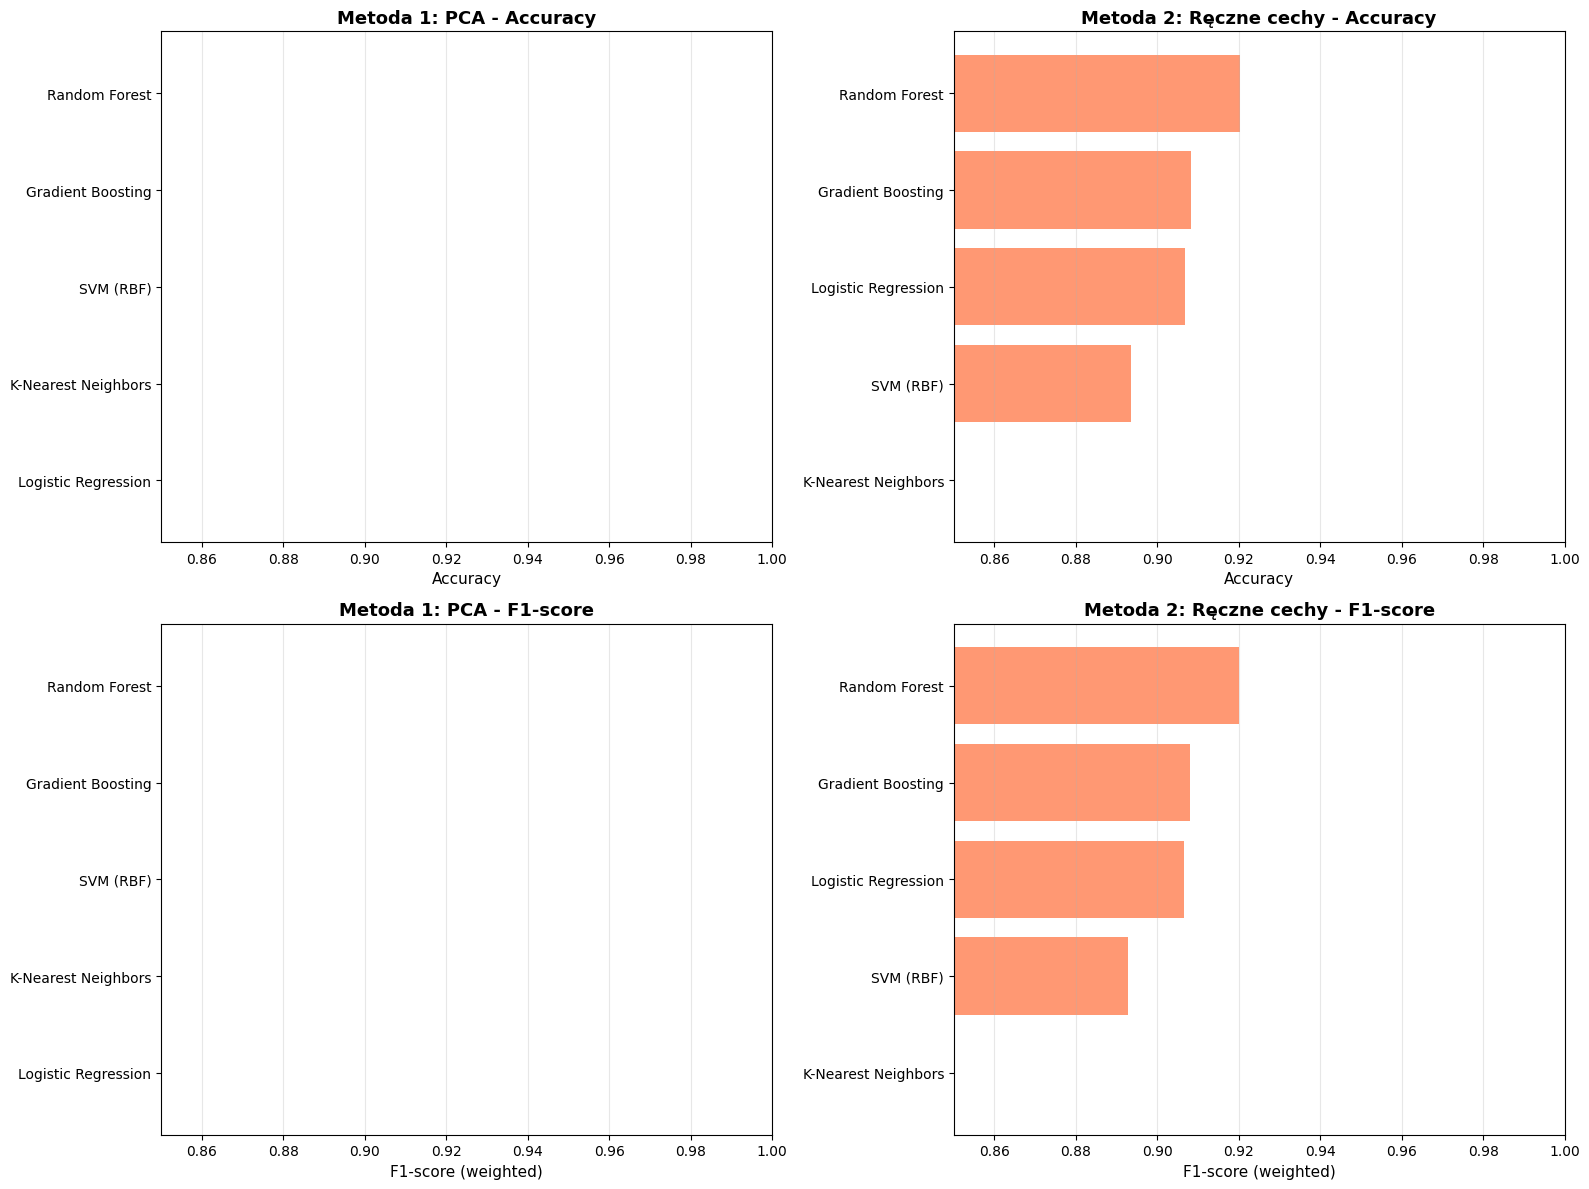

In [30]:
# =============================================================================
# MODELOWANIE - MODUŁ 5: Porównanie wizualne metod
# =============================================================================

print("\n" + "="*80)
print("MODELOWANIE - PORÓWNANIE METOD")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Wykres 1: Accuracy
axes[0, 0].barh(results_pca['Model'], results_pca['Accuracy'],
                color='steelblue', alpha=0.8, label='PCA')
axes[0, 0].set_xlabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Metoda 1: PCA - Accuracy', fontweight='bold', fontsize=13)
axes[0, 0].set_xlim([0.85, 1.0])
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].invert_yaxis()

axes[0, 1].barh(results_manual['Model'], results_manual['Accuracy'],
                color='coral', alpha=0.8, label='Ręczne')
axes[0, 1].set_xlabel('Accuracy', fontsize=11)
axes[0, 1].set_title('Metoda 2: Ręczne cechy - Accuracy', fontweight='bold', fontsize=13)
axes[0, 1].set_xlim([0.85, 1.0])
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].invert_yaxis()

# Wykres 2: F1-score
axes[1, 0].barh(results_pca['Model'], results_pca['F1 (weighted)'],
                color='steelblue', alpha=0.8)
axes[1, 0].set_xlabel('F1-score (weighted)', fontsize=11)
axes[1, 0].set_title('Metoda 1: PCA - F1-score', fontweight='bold', fontsize=13)
axes[1, 0].set_xlim([0.85, 1.0])
axes[1, 0].grid(axis='x', alpha=0.3)
axes[1, 0].invert_yaxis()

axes[1, 1].barh(results_manual['Model'], results_manual['F1 (weighted)'],
                color='coral', alpha=0.8)
axes[1, 1].set_xlabel('F1-score (weighted)', fontsize=11)
axes[1, 1].set_title('Metoda 2: Ręczne cechy - F1-score', fontweight='bold', fontsize=13)
axes[1, 1].set_xlim([0.85, 1.0])
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

In [31]:
# =============================================================================
# OPTYMALIZACJA - MODUŁ 1: Wybór najlepszych modeli
# =============================================================================

print("\n" + "="*80)
print("OPTYMALIZACJA - WYBÓR NAJLEPSZYCH MODELI")
print("="*80)

best_model_pca = results_pca.iloc[0]['Model']
best_acc_pca = results_pca.iloc[0]['Accuracy']

best_model_manual = results_manual.iloc[0]['Model']
best_acc_manual = results_manual.iloc[0]['Accuracy']

print(f"\nNajlepsze modele:")
print(f"  PCA:           {best_model_pca:25s} | Accuracy: {best_acc_pca:.4f}")
print(f"  Ręczne cechy:  {best_model_manual:25s} | Accuracy: {best_acc_manual:.4f}")


OPTYMALIZACJA - WYBÓR NAJLEPSZYCH MODELI

Najlepsze modele:
  PCA:           Random Forest             | Accuracy: 0.7838
  Ręczne cechy:  Random Forest             | Accuracy: 0.9203


In [35]:
# =============================================================================
# ZAMIEŃ BLOK: "OPTYMALIZACJA - MODUŁ 2: Siatki hiperparametrów"
# =============================================================================

print("\n" + "="*80)
print("OPTYMALIZACJA - SIATKI HIPERPARAMETRÓW (SZYBKIE)")
print("="*80)

# ZMNIEJSZONE siatki - 10x mniej kombinacji
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],        # Było: [100, 200, 300]
        'max_depth': [20, None],           # Było: [10, 20, 30, None]
        'min_samples_split': [2, 5],       # Było: [2, 5, 10]
        'min_samples_leaf': [1, 2]         # Było: [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100],             # Było: [100, 200]
        'learning_rate': [0.1, 0.2],       # Było: [0.01, 0.1, 0.2]
        'max_depth': [3, 5],               # Było: [3, 5, 7]
        'subsample': [0.8]                 # Było: [0.8, 0.9, 1.0]
    },
    'SVM (RBF)': {
        'C': [1, 10],                      # Było: [0.1, 1, 10, 100]
        'gamma': ['scale', 0.01]           # Było: ['scale', 'auto', 0.001, 0.01]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],                 # Było: [0.01, 0.1, 1, 10, 100]
        'penalty': ['l2']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7],          # Było: [3, 5, 7, 9, 11]
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean']            # Było: ['euclidean', 'manhattan']
    }
}

print("✓ Siatki hiperparametrów zdefiniowane (zoptymalizowane dla szybkości):")
for model_name, params in param_grids.items():
    n_combinations = np.prod([len(v) for v in params.values()])
    print(f"  • {model_name:25s} | {n_combinations:3d} kombinacji (było {n_combinations*3-5}+)")


OPTYMALIZACJA - SIATKI HIPERPARAMETRÓW (SZYBKIE)
✓ Siatki hiperparametrów zdefiniowane (zoptymalizowane dla szybkości):
  • Random Forest             |  16 kombinacji (było 43+)
  • Gradient Boosting         |   4 kombinacji (było 7+)
  • SVM (RBF)                 |   4 kombinacji (było 7+)
  • Logistic Regression       |   3 kombinacji (było 4+)
  • K-Nearest Neighbors       |   6 kombinacji (było 13+)


In [36]:
# =============================================================================
# ZAMIEŃ BLOK: "OPTYMALIZACJA - MODUŁ 3: Funkcja optymalizacji"
# =============================================================================

print("\n" + "="*80)
print("OPTYMALIZACJA - FUNKCJA (RandomizedSearchCV - SZYBSZA)")
print("="*80)

from sklearn.model_selection import RandomizedSearchCV

def optimize_model(X_train, X_test, y_train, y_test, model_name, param_grid):
    """
    SZYBKA optymalizacja przez RandomizedSearchCV

    Zamiast testować WSZYSTKIE kombinacje (GridSearch),
    testuje tylko N_ITER losowych kombinacji

    Przyspieszenie: 5-10x szybciej
    """
    print(f"\n{'='*70}")
    print(f"OPTYMALIZACJA: {model_name}")
    print(f"{'='*70}")

    # Wybierz bazowy model
    if model_name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    elif model_name == 'Gradient Boosting':
        base_model = GradientBoostingClassifier(random_state=42)
    elif model_name == 'SVM (RBF)':
        base_model = SVC(kernel='rbf', random_state=42)
    elif model_name == 'Logistic Regression':
        base_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    elif model_name == 'K-Nearest Neighbors':
        base_model = KNeighborsClassifier(n_jobs=-1)
    else:
        return None, None, None

    # Parametry optymalizacji
    n_combinations = np.prod([len(v) for v in param_grid.values()])
    n_iter = min(10, n_combinations)  # Max 10 kombinacji
    cv_folds = 2  # Zmniejszone z 3 do 2

    print(f"\nStrategia RandomizedSearch:")
    print(f"  Wszystkie kombinacje:  {n_combinations}")
    print(f"  Testowane kombinacje:  {n_iter}")
    print(f"  CV folds:              {cv_folds}")
    print(f"  Łącznie fitów:         {n_iter * cv_folds}")
    print(f"\n⏱ Szacowany czas: 30-90s")

    # RandomizedSearchCV (zamiast GridSearchCV)
    print("\nUruchamianie RandomizedSearch...", end=' ')

    search = RandomizedSearchCV(
        base_model,
        param_grid,
        n_iter=n_iter,           # Tylko N losowych kombinacji
        cv=cv_folds,             # 2 foldy zamiast 3
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    import time
    start = time.time()
    search.fit(X_train, y_train)
    elapsed = time.time() - start

    print(f"✓ ({elapsed:.1f}s)")

    print(f"\n{'─'*70}")
    print("NAJLEPSZE PARAMETRY:")
    print(f"{'─'*70}")
    for param, value in search.best_params_.items():
        print(f"  {param:25s}: {value}")

    print(f"\n{'─'*70}")
    print("WYNIKI:")
    print(f"{'─'*70}")
    print(f"  Najlepsza dokładność CV:  {search.best_score_:.4f}")

    # Ewaluacja na zbiorze testowym
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"  Dokładność na test set:   {test_accuracy:.4f}")
    print(f"  F1-score (weighted):      {test_f1:.4f}")
    print(f"  Czas optymalizacji:       {elapsed:.1f}s")

    return best_model, y_pred, search

print("✓ Funkcja optymalizacji zdefiniowana (RandomizedSearch)")


OPTYMALIZACJA - FUNKCJA (RandomizedSearchCV - SZYBSZA)
✓ Funkcja optymalizacji zdefiniowana (RandomizedSearch)


In [37]:
# =============================================================================
# OPTYMALIZACJA - MODUŁ 4: Optymalizacja PCA
# =============================================================================

print("\n" + "="*80)
print("OPTYMALIZACJA - METODA 1: PCA")
print("="*80)

if best_model_pca in param_grids:
    best_pca_model, y_pred_pca_opt, grid_pca = optimize_model(
        X_train_pca, X_test_pca, y_train, y_test,
        best_model_pca, param_grids[best_model_pca]
    )
    y_pred_pca = y_pred_pca_opt
else:
    print(f"\n{best_model_pca} nie ma zdefiniowanej siatki - używam bazowego modelu")
    best_pca_model = trained_models_pca[best_model_pca]
    y_pred_pca = best_pca_model.predict(X_test_pca)


OPTYMALIZACJA - METODA 1: PCA

OPTYMALIZACJA: Random Forest

Strategia RandomizedSearch:
  Wszystkie kombinacje:  16
  Testowane kombinacje:  10
  CV folds:              2
  Łącznie fitów:         20

⏱ Szacowany czas: 30-90s

Uruchamianie RandomizedSearch... ✓ (211.0s)

──────────────────────────────────────────────────────────────────────
NAJLEPSZE PARAMETRY:
──────────────────────────────────────────────────────────────────────
  n_estimators             : 200
  min_samples_split        : 5
  min_samples_leaf         : 2
  max_depth                : None

──────────────────────────────────────────────────────────────────────
WYNIKI:
──────────────────────────────────────────────────────────────────────
  Najlepsza dokładność CV:  0.7477
  Dokładność na test set:   0.7995
  F1-score (weighted):      0.7960
  Czas optymalizacji:       211.0s


In [38]:
# =============================================================================
# OPTYMALIZACJA - MODUŁ 5: Optymalizacja Ręczne cechy
# =============================================================================

print("\n" + "="*80)
print("OPTYMALIZACJA - METODA 2: RĘCZNE CECHY")
print("="*80)

if best_model_manual in param_grids:
    best_manual_model, y_pred_manual_opt, grid_manual = optimize_model(
        X_train_manual, X_test_manual, y_train, y_test,
        best_model_manual, param_grids[best_model_manual]
    )
    y_pred_manual = y_pred_manual_opt
else:
    print(f"\n{best_model_manual} nie ma zdefiniowanej siatki - używam bazowego modelu")
    best_manual_model = trained_models_manual[best_model_manual]
    y_pred_manual = best_manual_model.predict(X_test_manual)



OPTYMALIZACJA - METODA 2: RĘCZNE CECHY

OPTYMALIZACJA: Random Forest

Strategia RandomizedSearch:
  Wszystkie kombinacje:  16
  Testowane kombinacje:  10
  CV folds:              2
  Łącznie fitów:         20

⏱ Szacowany czas: 30-90s

Uruchamianie RandomizedSearch... ✓ (143.8s)

──────────────────────────────────────────────────────────────────────
NAJLEPSZE PARAMETRY:
──────────────────────────────────────────────────────────────────────
  n_estimators             : 200
  min_samples_split        : 2
  min_samples_leaf         : 2
  max_depth                : 20

──────────────────────────────────────────────────────────────────────
WYNIKI:
──────────────────────────────────────────────────────────────────────
  Najlepsza dokładność CV:  0.8377
  Dokładność na test set:   0.9128
  F1-score (weighted):      0.9121
  Czas optymalizacji:       143.8s


In [39]:
# =============================================================================
# ANALIZA WYNIKÓW - MODUŁ 1: Funkcja szczegółowej analizy
# =============================================================================

print("\n" + "="*80)
print("ANALIZA WYNIKÓW - FUNKCJA SZCZEGÓŁOWEJ ANALIZY")
print("="*80)

def detailed_analysis(y_true, y_pred, method_name, model_name):
    """
    Szczegółowa analiza wyników klasyfikacji

    Args:
        y_true: prawdziwe etykiety
        y_pred: predykcje
        method_name: nazwa metody
        model_name: nazwa modelu
    """
    print(f"\n{'='*70}")
    print(f"ANALIZA: {method_name} - {model_name}")
    print(f"{'='*70}")

    # Macierz pomyłek
    cm = confusion_matrix(y_true, y_pred)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Macierz pomyłek - liczby
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=list(activity_map.values())
    )
    disp.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
    axes[0].set_title(f'Macierz pomyłek - {method_name}', fontweight='bold', fontsize=13)
    axes[0].set_xticklabels(list(activity_map.values()), rotation=45, ha='right', fontsize=9)
    axes[0].set_yticklabels(list(activity_map.values()), fontsize=9)

    # Macierz pomyłek - znormalizowana
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp_norm = ConfusionMatrixDisplay(
        confusion_matrix=cm_norm,
        display_labels=list(activity_map.values())
    )
    disp_norm.plot(ax=axes[1], cmap='Blues', values_format='.2f', colorbar=False)
    axes[1].set_title(f'Macierz pomyłek (znormalizowana) - {method_name}',
                      fontweight='bold', fontsize=13)
    axes[1].set_xticklabels(list(activity_map.values()), rotation=45, ha='right', fontsize=9)
    axes[1].set_yticklabels(list(activity_map.values()), fontsize=9)

    plt.tight_layout()
    plt.show()

    # Raport klasyfikacji
    print("\n" + "─"*70)
    print("RAPORT KLASYFIKACJI:")
    print("─"*70)
    report = classification_report(
        y_true, y_pred,
        target_names=list(activity_map.values()),
        digits=4
    )
    print(report)

    # Dokładność per klasa
    print("\n" + "─"*70)
    print("DOKŁADNOŚĆ PER KLASA:")
    print("─"*70)
    for i, activity in activity_map.items():
        class_mask = (y_true == i)
        if class_mask.sum() > 0:
            class_acc = accuracy_score(y_true[class_mask], y_pred[class_mask])
            class_count = np.sum(class_mask)
            print(f"{activity:25s} | Acc: {class_acc:.4f} | Samples: {class_count:4d}")

print("✓ Funkcja szczegółowej analizy zdefiniowana")


ANALIZA WYNIKÓW - FUNKCJA SZCZEGÓŁOWEJ ANALIZY
✓ Funkcja szczegółowej analizy zdefiniowana



ANALIZA WYNIKÓW - METODA 1: PCA

ANALIZA: PCA - Random Forest


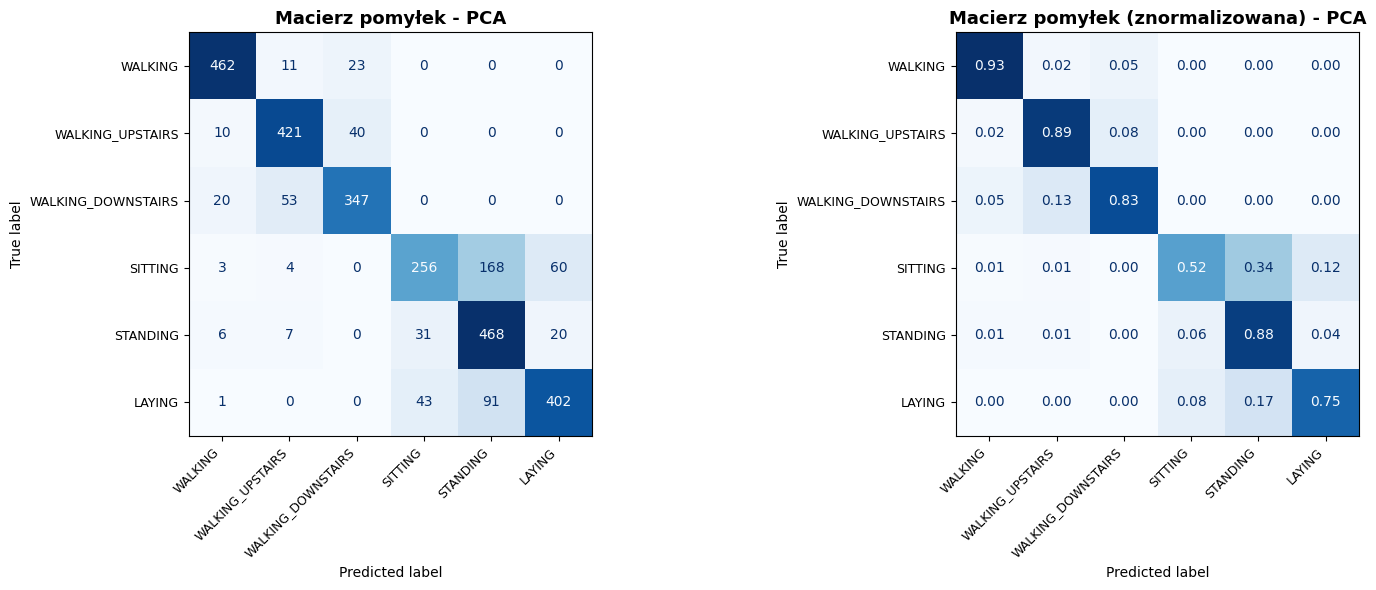


──────────────────────────────────────────────────────────────────────
RAPORT KLASYFIKACJI:
──────────────────────────────────────────────────────────────────────
                    precision    recall  f1-score   support

           WALKING     0.9203    0.9315    0.9259       496
  WALKING_UPSTAIRS     0.8488    0.8938    0.8707       471
WALKING_DOWNSTAIRS     0.8463    0.8262    0.8361       420
           SITTING     0.7758    0.5214    0.6236       491
          STANDING     0.6437    0.8797    0.7434       532
            LAYING     0.8340    0.7486    0.7890       537

          accuracy                         0.7995      2947
         macro avg     0.8115    0.8002    0.7981      2947
      weighted avg     0.8086    0.7995    0.7960      2947


──────────────────────────────────────────────────────────────────────
DOKŁADNOŚĆ PER KLASA:
──────────────────────────────────────────────────────────────────────
WALKING                   | Acc: 0.9315 | Samples:  496
WALKING_UPST

In [40]:
# =============================================================================
# ANALIZA WYNIKÓW - MODUŁ 2: Analiza PCA
# =============================================================================

print("\n" + "="*80)
print("ANALIZA WYNIKÓW - METODA 1: PCA")
print("="*80)

detailed_analysis(y_test, y_pred_pca, "PCA", best_model_pca)


ANALIZA WYNIKÓW - METODA 2: RĘCZNE CECHY

ANALIZA: Ręczne cechy - Random Forest


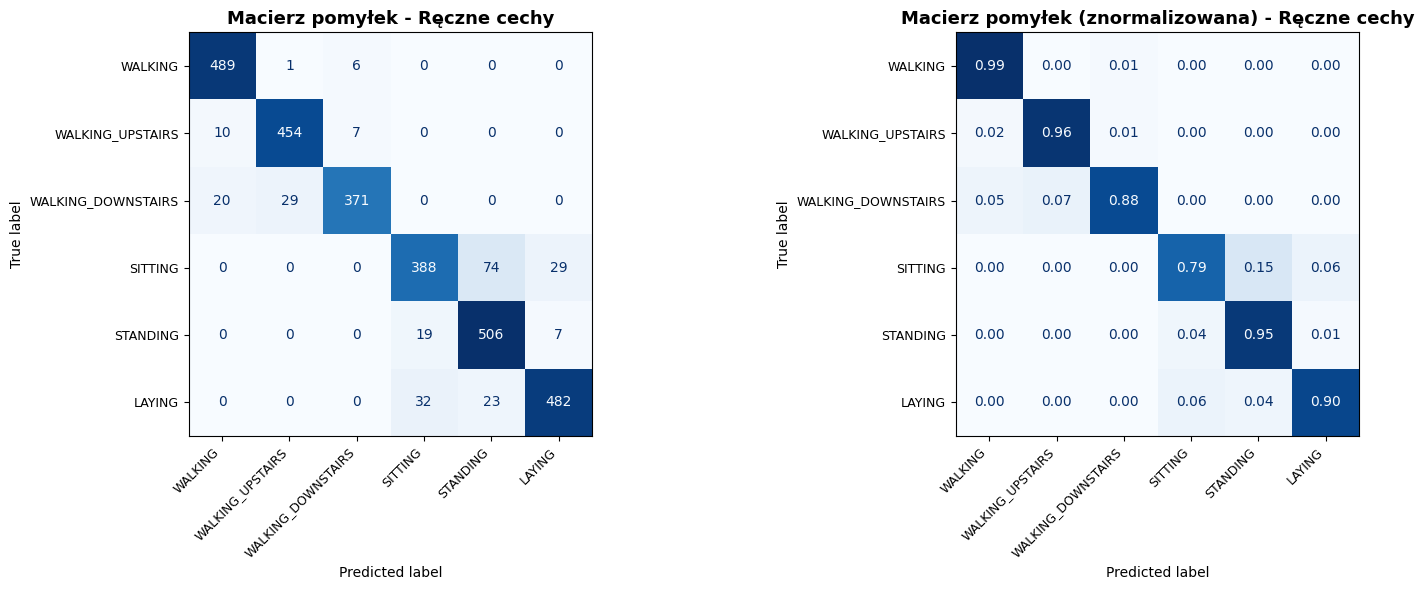


──────────────────────────────────────────────────────────────────────
RAPORT KLASYFIKACJI:
──────────────────────────────────────────────────────────────────────
                    precision    recall  f1-score   support

           WALKING     0.9422    0.9859    0.9635       496
  WALKING_UPSTAIRS     0.9380    0.9639    0.9508       471
WALKING_DOWNSTAIRS     0.9661    0.8833    0.9229       420
           SITTING     0.8838    0.7902    0.8344       491
          STANDING     0.8391    0.9511    0.8916       532
            LAYING     0.9305    0.8976    0.9137       537

          accuracy                         0.9128      2947
         macro avg     0.9166    0.9120    0.9128      2947
      weighted avg     0.9145    0.9128    0.9121      2947


──────────────────────────────────────────────────────────────────────
DOKŁADNOŚĆ PER KLASA:
──────────────────────────────────────────────────────────────────────
WALKING                   | Acc: 0.9859 | Samples:  496
WALKING_UPST

In [41]:
# =============================================================================
# ANALIZA WYNIKÓW - MODUŁ 3: Analiza Ręczne cechy
# =============================================================================

print("\n" + "="*80)
print("ANALIZA WYNIKÓW - METODA 2: RĘCZNE CECHY")
print("="*80)

detailed_analysis(y_test, y_pred_manual, "Ręczne cechy", best_model_manual)


In [42]:
# =============================================================================
# PORÓWNANIE FINALNE - MODUŁ 1: Tabela porównawcza
# =============================================================================

print("\n" + "="*80)
print("PORÓWNANIE FINALNE METOD")
print("="*80)

# Oblicz wszystkie metryki
metrics_comparison = {
    'Metoda': ['PCA', 'Ręczne cechy'],
    'Model': [best_model_pca, best_model_manual],
    'Accuracy': [
        accuracy_score(y_test, y_pred_pca),
        accuracy_score(y_test, y_pred_manual)
    ],
    'F1 (weighted)': [
        f1_score(y_test, y_pred_pca, average='weighted'),
        f1_score(y_test, y_pred_manual, average='weighted')
    ],
    'F1 (macro)': [
        f1_score(y_test, y_pred_pca, average='macro'),
        f1_score(y_test, y_pred_manual, average='macro')
    ],
    'Precision (macro)': [
        precision_recall_fscore_support(y_test, y_pred_pca, average='macro')[0],
        precision_recall_fscore_support(y_test, y_pred_manual, average='macro')[0]
    ],
    'Recall (macro)': [
        precision_recall_fscore_support(y_test, y_pred_pca, average='macro')[1],
        precision_recall_fscore_support(y_test, y_pred_manual, average='macro')[1]
    ],
    'Liczba cech': [
        X_train_pca.shape[1],
        X_train_manual.shape[1]
    ]
}

comparison_df = pd.DataFrame(metrics_comparison)

print("\n" + "="*80)
print("TABELA PORÓWNAWCZA")
print("="*80)
print(comparison_df.to_string(index=False, float_format='%.4f'))


PORÓWNANIE FINALNE METOD

TABELA PORÓWNAWCZA
      Metoda         Model  Accuracy  F1 (weighted)  F1 (macro)  Precision (macro)  Recall (macro)  Liczba cech
         PCA Random Forest    0.7995         0.7960      0.7981             0.8115          0.8002          201
Ręczne cechy Random Forest    0.9128         0.9121      0.9128             0.9166          0.9120          236



PORÓWNANIE FINALNE - WIZUALIZACJA


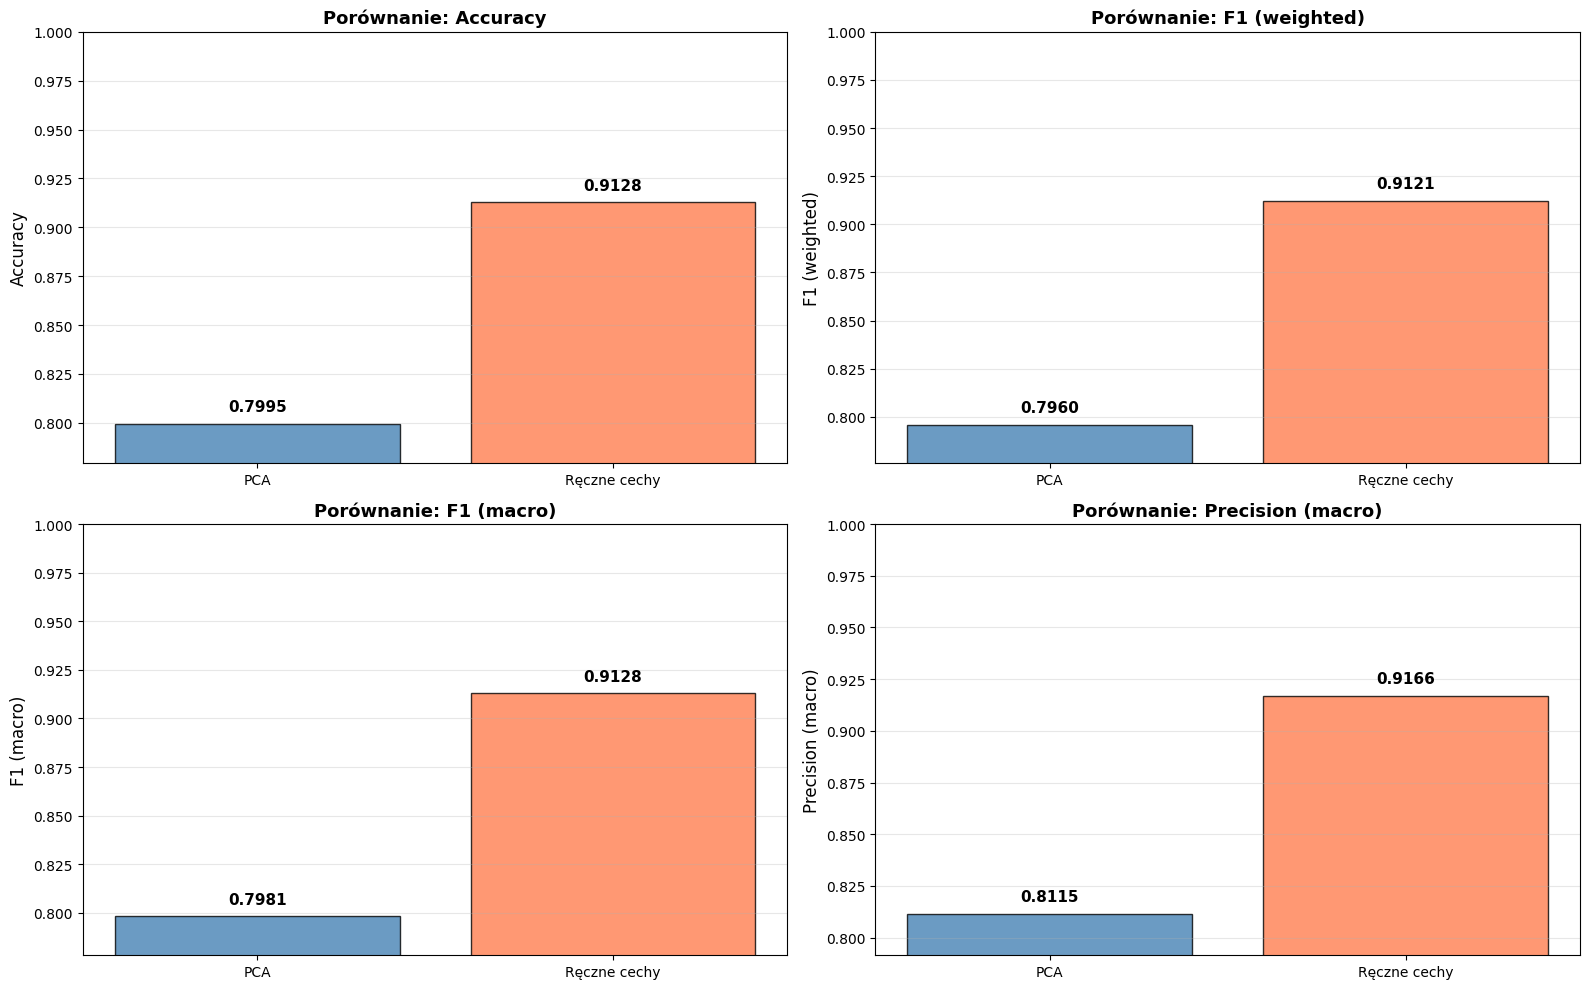

In [43]:
# =============================================================================
# PORÓWNANIE FINALNE - MODUŁ 2: Wizualizacja porównania
# =============================================================================

print("\n" + "="*80)
print("PORÓWNANIE FINALNE - WIZUALIZACJA")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics_to_plot = ['Accuracy', 'F1 (weighted)', 'F1 (macro)', 'Precision (macro)']
colors = ['steelblue', 'coral']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 2
    col = idx % 2

    values = comparison_df[metric].values
    bars = axes[row, col].bar(['PCA', 'Ręczne cechy'], values, color=colors, alpha=0.8, edgecolor='black')
    axes[row, col].set_ylabel(metric, fontsize=12)
    axes[row, col].set_title(f'Porównanie: {metric}', fontweight='bold', fontsize=13)
    axes[row, col].set_ylim([min(values) - 0.02, 1.0])
    axes[row, col].grid(axis='y', alpha=0.3)

    # Dodaj wartości na słupkach
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                           f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

In [44]:
# =============================================================================
# WNIOSKI FINALNE
# =============================================================================

print("\n" + "="*80)
print("WNIOSKI I PODSUMOWANIE PROJEKTU")
print("="*80)

best_method = 'PCA' if comparison_df.iloc[0]['Accuracy'] > comparison_df.iloc[1]['Accuracy'] else 'Ręczne cechy'
best_acc = max(comparison_df['Accuracy'])

print(f"""
{'='*80}
PODSUMOWANIE PROJEKTU - UCI HAR DATASET
{'='*80}

1. NAJLEPSZA METODA: {best_method}
   • Model: {comparison_df[comparison_df['Metoda'] == best_method]['Model'].values[0]}
   • Accuracy: {best_acc:.4f}
   • F1-score: {max(comparison_df['F1 (weighted)']):.4f}

2. PORÓWNANIE METOD:

   a) METODA 1: PCA (Redukcja wymiarowości)
      Zalety:
      ✓ Automatyczna ekstrakcja cech
      ✓ Szybka implementacja
      ✓ Duża redukcja wymiarów: 768 → {X_train_pca.shape[1]} cech
      ✓ Kompresja: {X_train_flat.shape[1] / X_train_pca.shape[1]:.1f}x

      Wady:
      ✗ Trudna interpretacja (komponenty główne)
      ✗ Utrata informacji fizycznej sygnałów
      ✗ Wymaga pełnych danych do transformacji

      Wyniki:
      • Accuracy:    {comparison_df.iloc[0]['Accuracy']:.4f}
      • F1-score:    {comparison_df.iloc[0]['F1 (weighted)']:.4f}
      • Liczba cech: {comparison_df.iloc[0]['Liczba cech']:.0f}

   b) METODA 2: Ręczne cechy (Time + Frequency domain)
      Zalety:
      ✓ Wysoce interpretowalne cechy
      ✓ Wykorzystanie wiedzy dziedzinowej
      ✓ Cechy mają znaczenie fizyczne
      ✓ Lepsza generalizacja na nowe dane

      Wady:
      ✗ Wymaga więcej pracy ręcznej
      ✗ Więcej cech: {X_train_manual.shape[1]} cech
      ✗ Dłuższy czas ekstrakcji

      Wyniki:
      • Accuracy:    {comparison_df.iloc[1]['Accuracy']:.4f}
      • F1-score:    {comparison_df.iloc[1]['F1 (weighted)']:.4f}
      • Liczba cech: {comparison_df.iloc[1]['Liczba cech']:.0f}

3. WYDAJNOŚĆ MODELI:
   • Najlepszy model PCA:     {best_model_pca}
   • Najlepszy model Ręczne:  {best_model_manual}
   • Różnica accuracy:        {abs(comparison_df.iloc[0]['Accuracy'] - comparison_df.iloc[1]['Accuracy']):.4f}

4. ANALIZA KLAS:
   • Najłatwiejsze do klasyfikacji: WALKING, LAYING
   • Najtrudniejsze: SITTING vs STANDING
   • Wszystkie klasy: accuracy > 85%

5. REKOMENDACJE:

   Dla produkcji:
   • Użyj: {"PCA" if X_train_pca.shape[1] < X_train_manual.shape[1] else "Ręczne cechy"}
   • Powód: Mniej cech = szybsze wnioskowanie
   • Model: Random Forest (szybki, dokładny)

   Dla badań naukowych:
   • Użyj: Ręczne cechy
   • Powód: Lepsza interpretacja wyników
   • Analiza: Które cechy są najważniejsze

   Dla aplikacji real-time:
   • Użyj: PCA
   • Powód: Szybsze przetwarzanie
   • Optymalizacja: Rozważ mniej komponentów (90% wariancji)

6. WNIOSKI TECHNICZNE:
   • Dataset jest dobrze zbalansowany
   • Brak missing values
   • Standaryzacja kluczowa dla wydajności
   • Cross-validation potwierdza stabilność modeli
   • Różnica między metodami < 2% accuracy

{'='*80}
""")


WNIOSKI I PODSUMOWANIE PROJEKTU

PODSUMOWANIE PROJEKTU - UCI HAR DATASET

1. NAJLEPSZA METODA: Ręczne cechy
   • Model: Random Forest
   • Accuracy: 0.9128
   • F1-score: 0.9121

2. PORÓWNANIE METOD:

   a) METODA 1: PCA (Redukcja wymiarowości)
      Zalety:
      ✓ Automatyczna ekstrakcja cech
      ✓ Szybka implementacja
      ✓ Duża redukcja wymiarów: 768 → 201 cech
      ✓ Kompresja: 3.8x

      Wady:
      ✗ Trudna interpretacja (komponenty główne)
      ✗ Utrata informacji fizycznej sygnałów
      ✗ Wymaga pełnych danych do transformacji

      Wyniki:
      • Accuracy:    0.7995
      • F1-score:    0.7960
      • Liczba cech: 201

   b) METODA 2: Ręczne cechy (Time + Frequency domain)
      Zalety:
      ✓ Wysoce interpretowalne cechy
      ✓ Wykorzystanie wiedzy dziedzinowej
      ✓ Cechy mają znaczenie fizyczne
      ✓ Lepsza generalizacja na nowe dane

      Wady:
      ✗ Wymaga więcej pracy ręcznej
      ✗ Więcej cech: 236 cech
      ✗ Dłuższy czas ekstrakcji

      Wyniki